## Define natural priors

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'pdf')

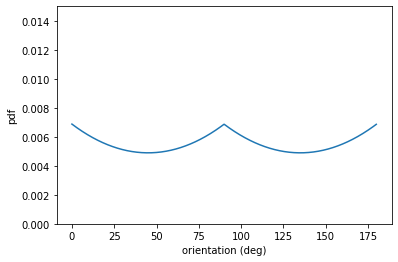

In [2]:
# "Natural prior" (Girshick et al. 2011, fig.6)
n_ori = 1000
a = 2e-4
b = 1

dori = 180 / n_ori
stim_dirs = np.float32(np.arange(0, 180, dori))
stim_p = np.zeros(n_ori)
midindx = np.argmin(np.abs(stim_dirs-90))

stim_p[:midindx] = a*(np.arange(0, stim_dirs[midindx], stim_dirs[midindx] / midindx)-45)**2 + b
stim_p[midindx:] = a*(np.arange(stim_dirs[midindx+1],
                               180, (180-stim_dirs[midindx+1]) / (n_ori-midindx)
                              )-135)**2 + b
plt.figure()
stim_p = stim_p/np.sum(stim_p)
plt.plot(stim_dirs,stim_p/dori)
plt.ylim([0,0.015])
plt.xlabel('orientation (deg)')
plt.ylabel('pdf')

## Train network from stimuli distributed with the natural statistics

In [3]:
import sys, os, time

import copy
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')
from det_rnn import *
import det_rnn.train as utils_train
import det_rnn.analysis as utils_analysis
import tensorflow as tf
from det_rnn.train.model import Model
from utils.plotfnc import *

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0-dev20200519
Num GPUs Available:  0


### Generate stimulus

In [4]:
print('batchsize = ' + str(par['batch_size']))
par

batchsize = 2024


{'design': {'iti': (0, 1.5),
  'stim': (1.5, 3.0),
  'delay': (3.0, 4.5),
  'estim': (4.5, 6.0)},
 'output_range': 'design',
 'dead': 'design',
 'mask': {'iti': 1.0,
  'stim': 1.0,
  'delay': 1.0,
  'estim': 10.0,
  'rule_iti': 2.0,
  'rule_stim': 2.0,
  'rule_delay': 2.0,
  'rule_estim': 20.0},
 'input_rule': 'design',
 'output_rule': 'design',
 'input_rule_strength': 0.8,
 'output_rule_strength': 0.8,
 'type': 'orientation',
 'stim_dist': 'uniform',
 'natural_a': 0.0002,
 'trial_per_subblock': 1,
 'stim_encoding': 'single',
 'resp_decoding': 'disc',
 'exc_inh_prop': 0.8,
 'modular': False,
 'connect_prob': 0.1,
 'dt': 10.0,
 'membrane_time_constant': 100,
 'input_mean': 0.0,
 'noise_in_sd': 0.1,
 'noise_rnn_sd': 0.5,
 'strength_input': 0.8,
 'strength_output': 0.8,
 'kappa': 2,
 'orientation_cost': 1,
 'n_iterations': 300,
 'iters_between_outputs': 100,
 'n_receptive_fields': 1,
 'n_tuned_input': 24,
 'n_tuned_output': 24,
 'n_ori': 24,
 'noise_mean': 0,
 'noise_sd': 0.005,
 'n_recal

In [5]:
# training set
par_train = copy.deepcopy(par)
# use "natural prior"
par_train['stim_dist'] = 'natural'
par_train['natural_a'] = 2e-4
par_train['n_ori'] = 1000 # make it somewhat continuous
par_train = update_parameters(par_train)
stim_train = Stimulus(par_train)

# testing set; for testing the 24 orientations
par_test = copy.deepcopy(par)
par_test['stim_dist'] = 'natural'
par_test['natural_a'] = 2e-4
par_test = update_parameters(par_test)
stim_test = Stimulus(par_test)   # the argument `par` may be omitted

In [6]:
print('train n_ori = ' + str(par_train['n_ori']))
print('test n_ori = ' + str(par_test['n_ori']))

24

orientation = 175.5


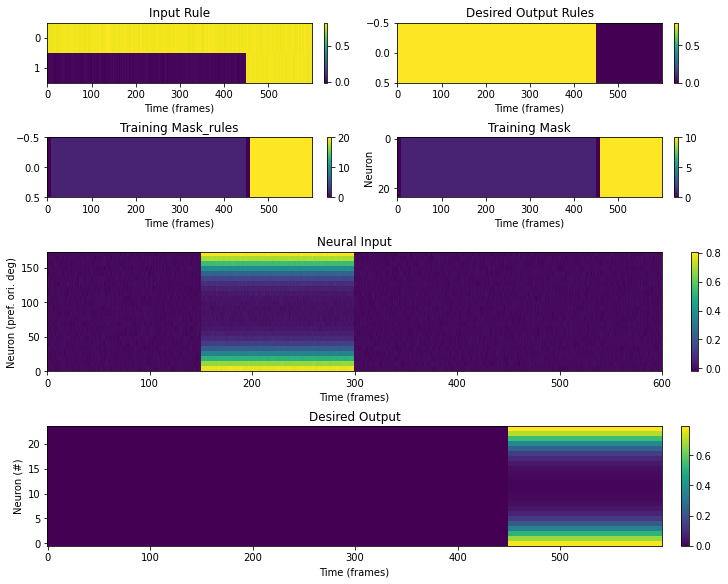

In [7]:
# check stimulus
train_data = stim_train.generate_trial()
random_trial_num = np.random.randint(stim_train.batch_size)
target_ori = np.arange(0,180,180/par_train['n_ori'])[train_data['stimulus_ori'][random_trial_num]]
print('orientation = ' + str(target_ori))
plot_trial(stim_train, train_data,TEST_TRIAL=random_trial_num)

orientation = 172.5


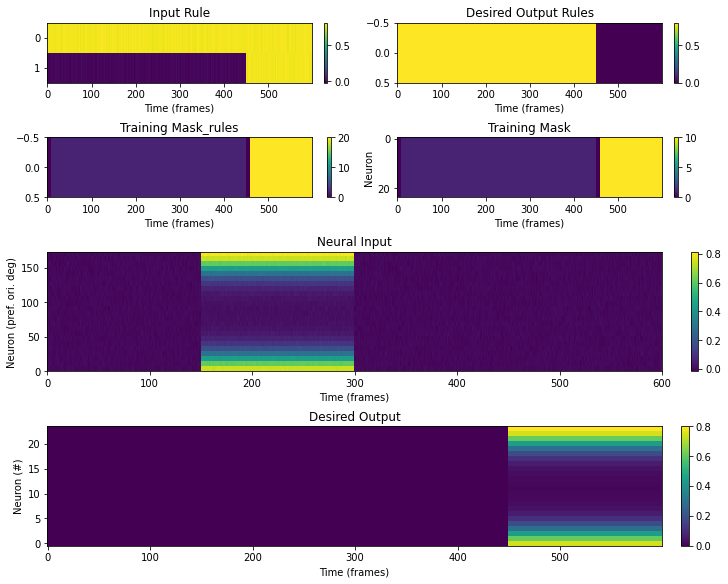

In [8]:
test_data = stim_test.generate_trial(balanced=True)
random_trial_num = len(test_data['stimulus_ori'])-2
#random_trial_num = np.random.randint(len(test_data['stimulus_ori']))
target_ori = np.arange(0,180,180/par_test['n_ori'])[test_data['stimulus_ori'][random_trial_num]]
print('orientation = ' + str(target_ori))
plot_trial(stim_test, test_data,TEST_TRIAL=random_trial_num)

In [ ]:
# Check the stimulus distribution in balanced trial


### Train on 24 orientations
Just to see if it works.
Note that this gives us the prior shape.


 Training performance: 
Iter.    0 | Performance -0.0049 | Loss 24776.6270 | Spike loss 142.3105
Testing performance: 
Iter.    0 | Performance 0.0000 | Loss 14863.8125 | Spike loss 109.7063
Instructions for updating:
Use tf.identity instead.


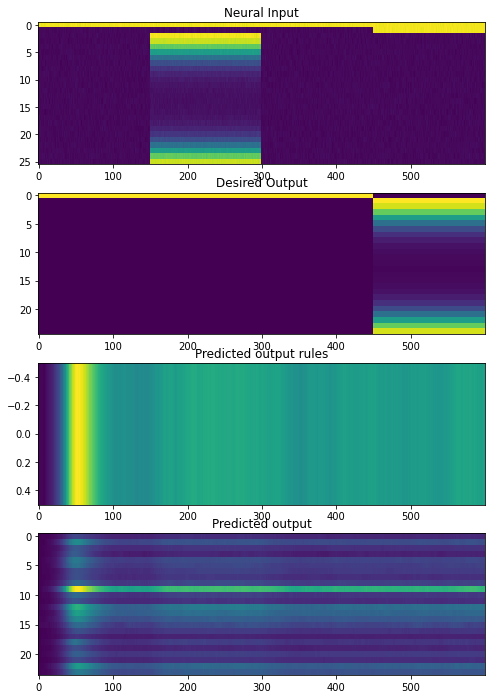

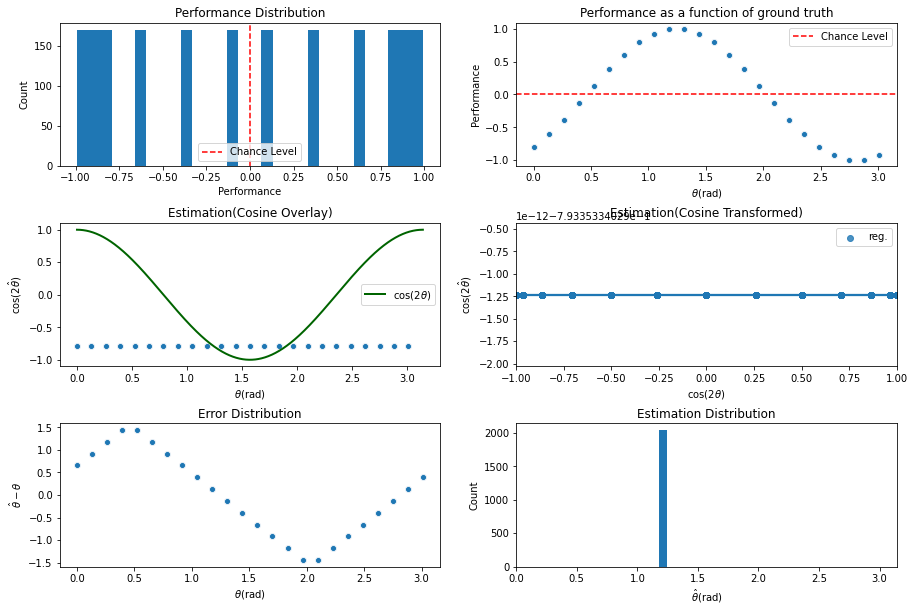

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter0\assets

 Training performance: 
Iter.    1 | Performance -0.0066 | Loss 14851.0918 | Spike loss 109.7147
Testing performance: 
Iter.    1 | Performance 0.0000 | Loss 7328.1265 | Spike loss 75.8377

 Training performance: 
Iter.    2 | Performance -0.0157 | Loss 7330.8706 | Spike loss 75.9016
Testing performance: 
Iter.    2 | Performance 0.0000 | Loss 1742.9922 | Spike loss 35.6020

 Training performance: 
Iter.    3 | Performance -0.0291 | Loss 1744.3448 | Spike loss 35.6838
Testing performance: 
Iter.    3 | Performance 0.0000 | Loss 640.4365 | Spike loss 19.6028

 Training performance: 
Iter.    4 | Performance 0.0125 | Loss 644.1546 | Spike loss 19.6926
Testing performance: 
Iter.    4 | Performance 0.0001 | Loss 234.3017 | Spike loss 11.7585

 Training performance: 
Iter.    5 | Performance 0.0053 | Loss 235.3078 | Spike loss 11.8001
Testing performance: 
Iter.    5 | Performance -0.0004 | Loss 

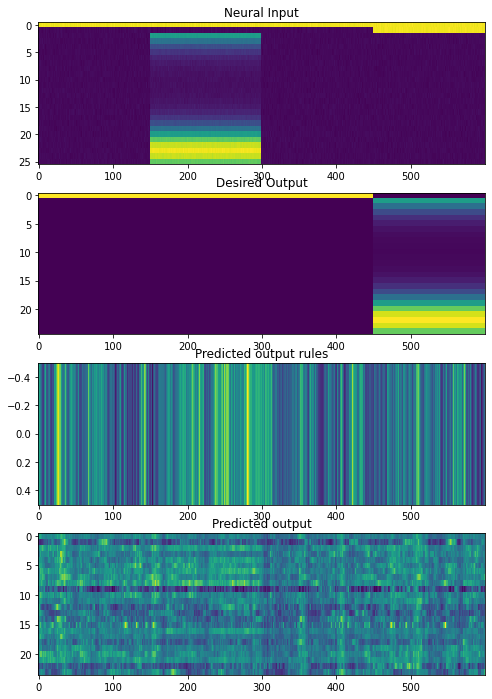

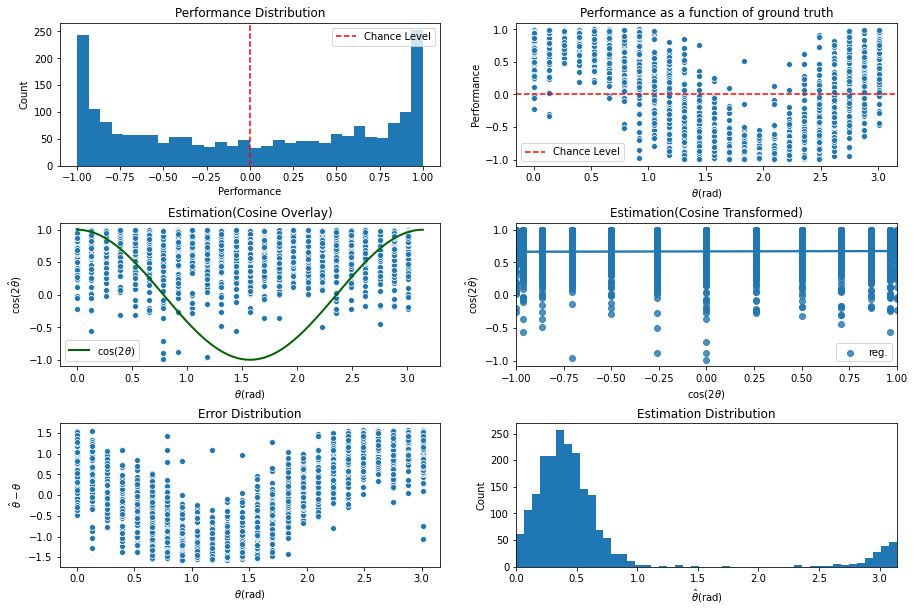

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter25\assets

 Training performance: 
Iter.   26 | Performance 0.0063 | Loss 1.5945 | Spike loss 0.6576
Testing performance: 
Iter.   26 | Performance 0.0047 | Loss 1.5138 | Spike loss 0.6581

 Training performance: 
Iter.   27 | Performance 0.0307 | Loss 1.5160 | Spike loss 0.6610
Testing performance: 
Iter.   27 | Performance -0.0028 | Loss 1.4430 | Spike loss 0.6621

 Training performance: 
Iter.   28 | Performance -0.0073 | Loss 1.4392 | Spike loss 0.6638
Testing performance: 
Iter.   28 | Performance 0.0039 | Loss 1.3682 | Spike loss 0.6672

 Training performance: 
Iter.   29 | Performance -0.0065 | Loss 1.3673 | Spike loss 0.6692
Testing performance: 
Iter.   29 | Performance -0.0059 | Loss 1.3145 | Spike loss 0.6741

 Training performance: 
Iter.   30 | Performance -0.0025 | Loss 1.3104 | Spike loss 0.6755
Testing performance: 
Iter.   30 | Performance -0.0022 | Loss 1.2647 | Spike loss 0.6806

 Tr

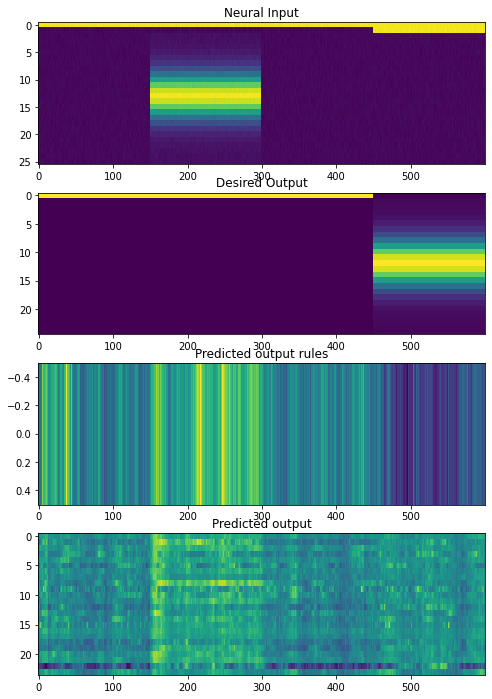

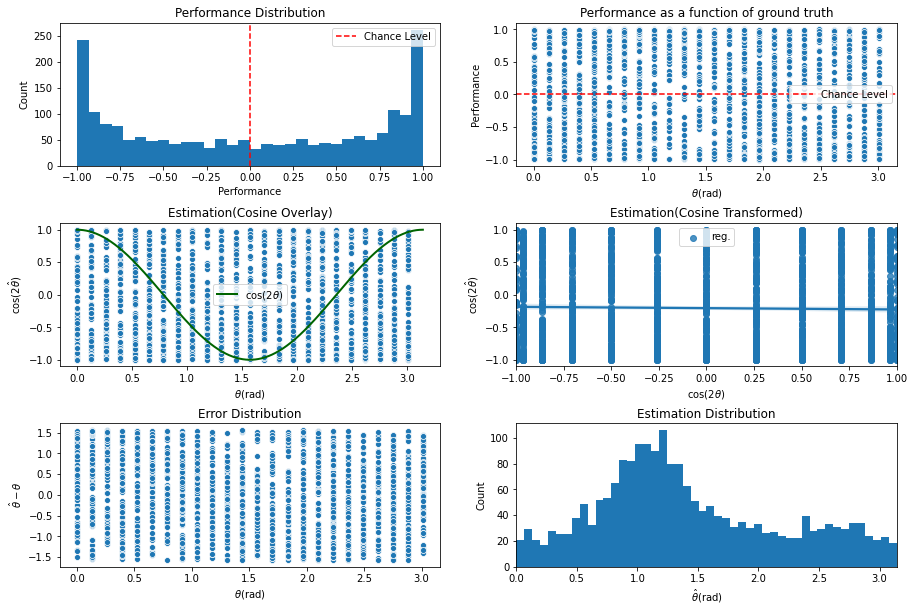

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter50\assets

 Training performance: 
Iter.   51 | Performance 0.0089 | Loss 0.6671 | Spike loss 1.0675
Testing performance: 
Iter.   51 | Performance 0.0060 | Loss 0.6573 | Spike loss 1.0967

 Training performance: 
Iter.   52 | Performance -0.0285 | Loss 0.6567 | Spike loss 1.1023
Testing performance: 
Iter.   52 | Performance 0.0071 | Loss 0.6413 | Spike loss 1.1235

 Training performance: 
Iter.   53 | Performance 0.0017 | Loss 0.6416 | Spike loss 1.1276
Testing performance: 
Iter.   53 | Performance 0.0005 | Loss 0.6293 | Spike loss 1.1498

 Training performance: 
Iter.   54 | Performance 0.0046 | Loss 0.6290 | Spike loss 1.1537
Testing performance: 
Iter.   54 | Performance 0.0072 | Loss 0.6180 | Spike loss 1.1780

 Training performance: 
Iter.   55 | Performance -0.0260 | Loss 0.6192 | Spike loss 1.1794
Testing performance: 
Iter.   55 | Performance 0.0107 | Loss 0.6073 | Spike loss 1.2093

 Traini

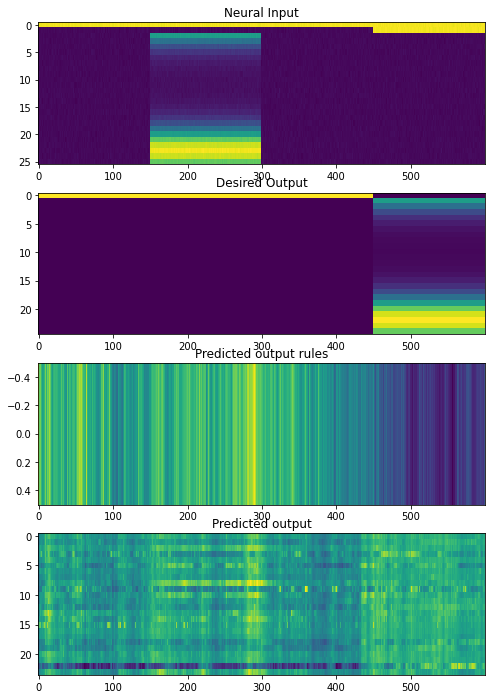

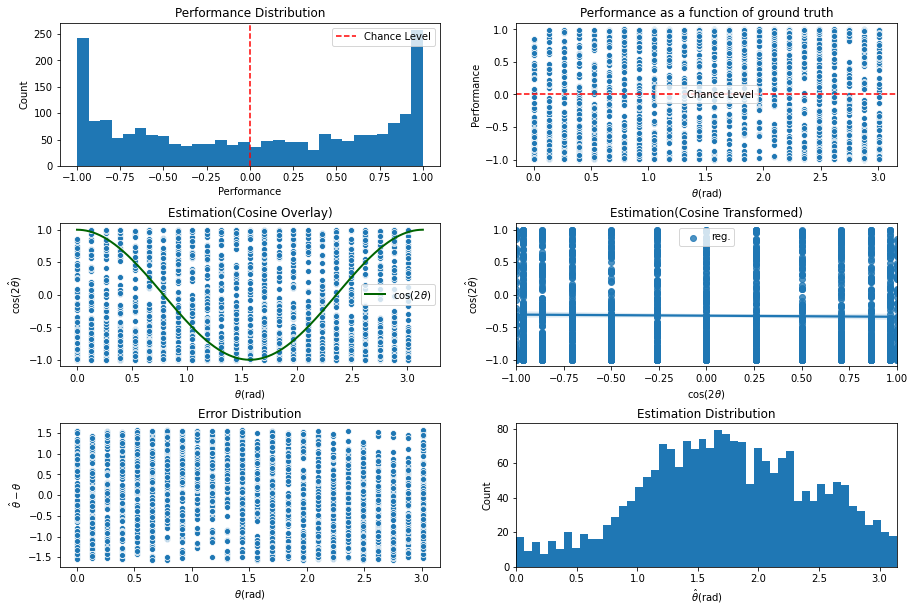

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter75\assets

 Training performance: 
Iter.   76 | Performance 0.0612 | Loss 0.4840 | Spike loss 1.4808
Testing performance: 
Iter.   76 | Performance 0.0390 | Loss 0.4793 | Spike loss 1.4847

 Training performance: 
Iter.   77 | Performance 0.0566 | Loss 0.4780 | Spike loss 1.4838
Testing performance: 
Iter.   77 | Performance 0.0477 | Loss 0.4757 | Spike loss 1.4770

 Training performance: 
Iter.   78 | Performance 0.0435 | Loss 0.4762 | Spike loss 1.4778
Testing performance: 
Iter.   78 | Performance 0.0155 | Loss 0.4687 | Spike loss 1.4779

 Training performance: 
Iter.   79 | Performance 0.0527 | Loss 0.4717 | Spike loss 1.4767
Testing performance: 
Iter.   79 | Performance 0.0202 | Loss 0.4672 | Spike loss 1.4744

 Training performance: 
Iter.   80 | Performance 0.0469 | Loss 0.4681 | Spike loss 1.4739
Testing performance: 
Iter.   80 | Performance 0.0167 | Loss 0.4661 | Spike loss 1.4725

 Training

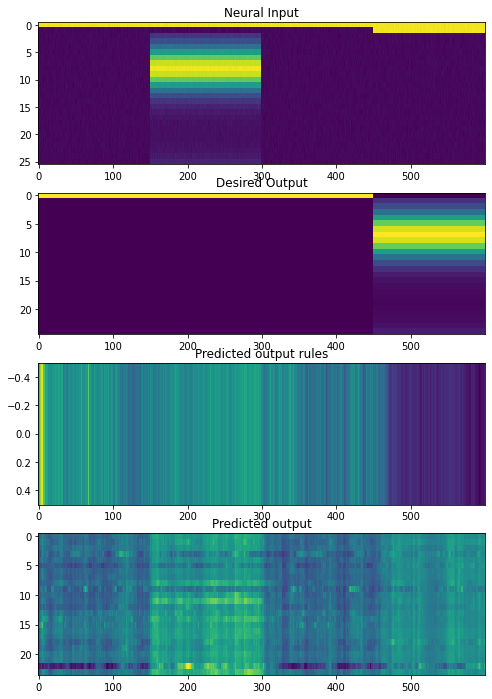

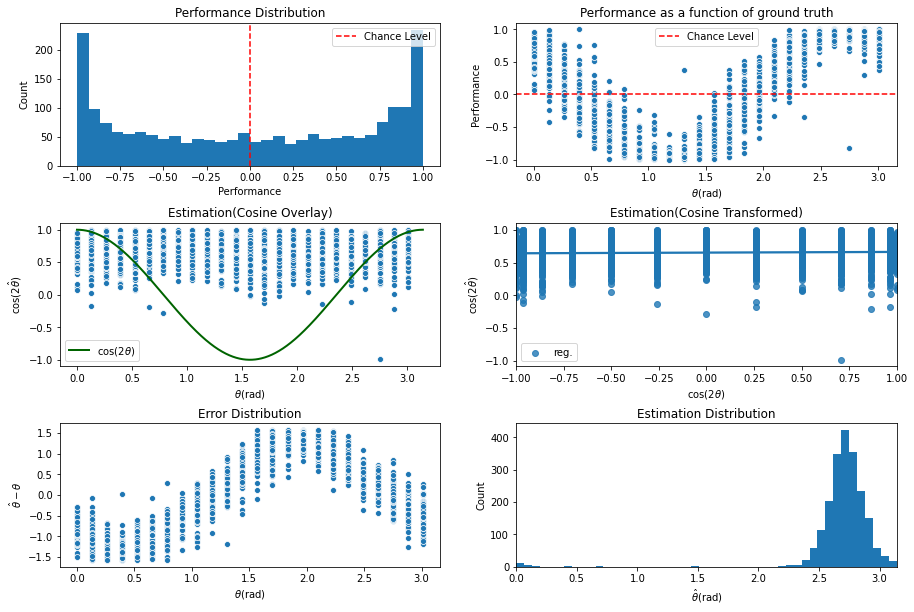

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter100\assets

 Training performance: 
Iter.  101 | Performance 0.0133 | Loss 0.4252 | Spike loss 1.7959
Testing performance: 
Iter.  101 | Performance 0.0250 | Loss 0.4166 | Spike loss 1.8268

 Training performance: 
Iter.  102 | Performance 0.0283 | Loss 0.4169 | Spike loss 1.8250
Testing performance: 
Iter.  102 | Performance 0.0325 | Loss 0.4240 | Spike loss 1.8468

 Training performance: 
Iter.  103 | Performance 0.0554 | Loss 0.4246 | Spike loss 1.8530
Testing performance: 
Iter.  103 | Performance 0.0500 | Loss 0.4298 | Spike loss 1.8594

 Training performance: 
Iter.  104 | Performance 0.0287 | Loss 0.4307 | Spike loss 1.8582
Testing performance: 
Iter.  104 | Performance 0.0427 | Loss 0.4217 | Spike loss 1.8519

 Training performance: 
Iter.  105 | Performance 0.0869 | Loss 0.4227 | Spike loss 1.8540
Testing performance: 
Iter.  105 | Performance 0.0524 | Loss 0.4130 | Spike loss 1.8366

 Trainin

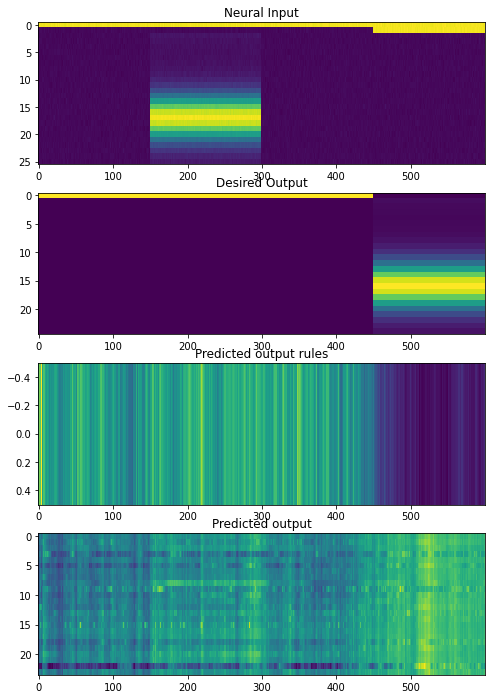

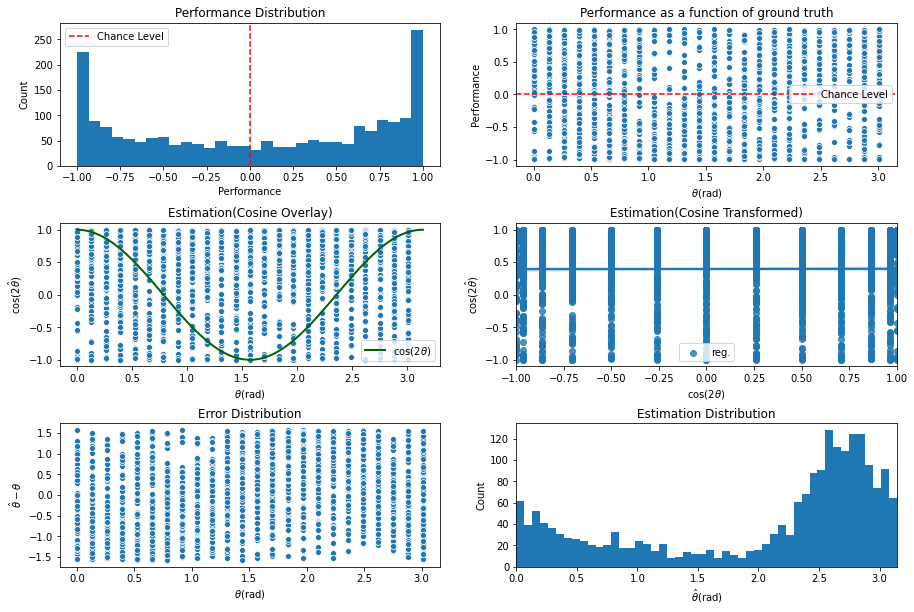

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter125\assets

 Training performance: 
Iter.  126 | Performance 0.0891 | Loss 0.3950 | Spike loss 1.9850
Testing performance: 
Iter.  126 | Performance 0.0500 | Loss 0.4000 | Spike loss 2.0094

 Training performance: 
Iter.  127 | Performance 0.0608 | Loss 0.4001 | Spike loss 2.0084
Testing performance: 
Iter.  127 | Performance 0.0317 | Loss 0.4079 | Spike loss 2.0190

 Training performance: 
Iter.  128 | Performance 0.0801 | Loss 0.4075 | Spike loss 2.0200
Testing performance: 
Iter.  128 | Performance 0.0530 | Loss 0.4037 | Spike loss 2.0182

 Training performance: 
Iter.  129 | Performance 0.0267 | Loss 0.4041 | Spike loss 2.0138
Testing performance: 
Iter.  129 | Performance 0.0342 | Loss 0.3932 | Spike loss 1.9958

 Training performance: 
Iter.  130 | Performance 0.0389 | Loss 0.3926 | Spike loss 2.0002
Testing performance: 
Iter.  130 | Performance 0.0469 | Loss 0.3979 | Spike loss 1.9817

 Trainin

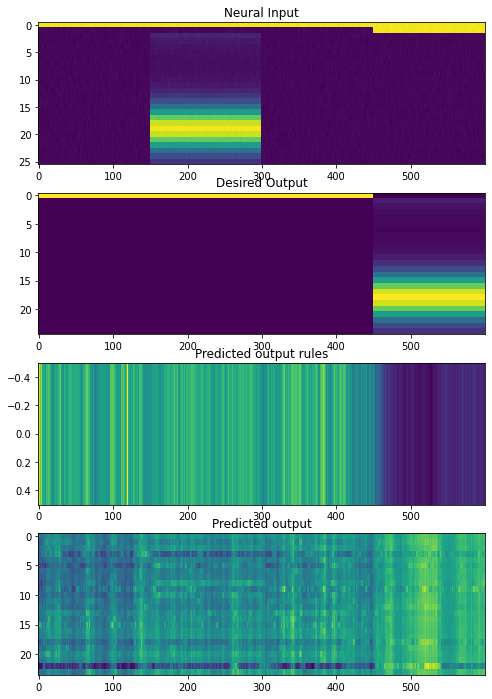

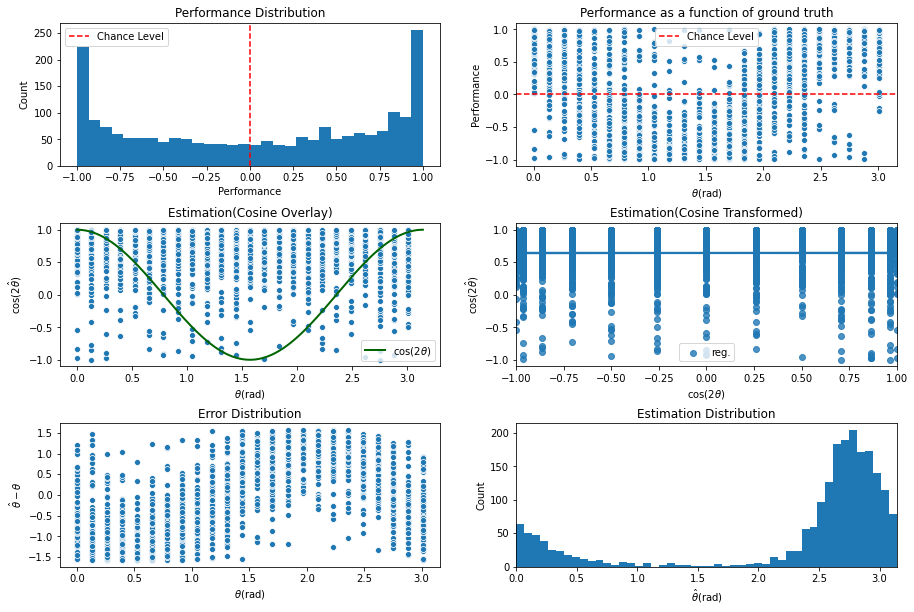

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter150\assets

 Training performance: 
Iter.  151 | Performance 0.0387 | Loss 0.3886 | Spike loss 2.0985
Testing performance: 
Iter.  151 | Performance 0.0734 | Loss 0.3963 | Spike loss 2.1018

 Training performance: 
Iter.  152 | Performance 0.0339 | Loss 0.3956 | Spike loss 2.1037
Testing performance: 
Iter.  152 | Performance 0.0515 | Loss 0.3930 | Spike loss 2.1024

 Training performance: 
Iter.  153 | Performance 0.0497 | Loss 0.3929 | Spike loss 2.0962
Testing performance: 
Iter.  153 | Performance 0.0558 | Loss 0.3825 | Spike loss 2.0841

 Training performance: 
Iter.  154 | Performance 0.0862 | Loss 0.3829 | Spike loss 2.0757
Testing performance: 
Iter.  154 | Performance 0.0749 | Loss 0.3863 | Spike loss 2.0725

 Training performance: 
Iter.  155 | Performance 0.0525 | Loss 0.3862 | Spike loss 2.0778
Testing performance: 
Iter.  155 | Performance 0.0676 | Loss 0.3928 | Spike loss 2.0670

 Trainin

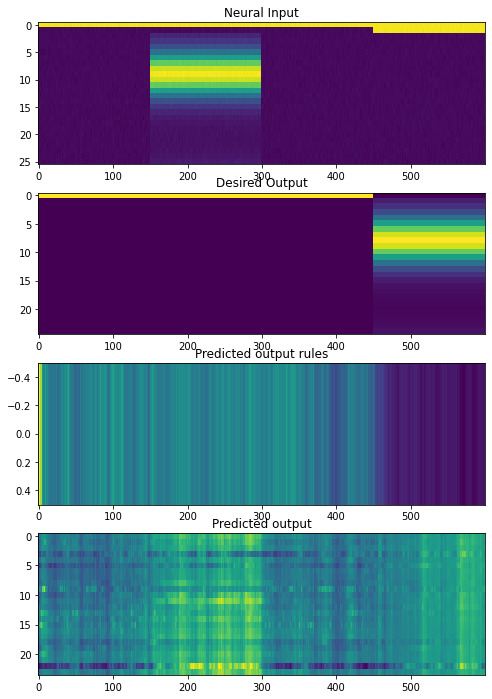

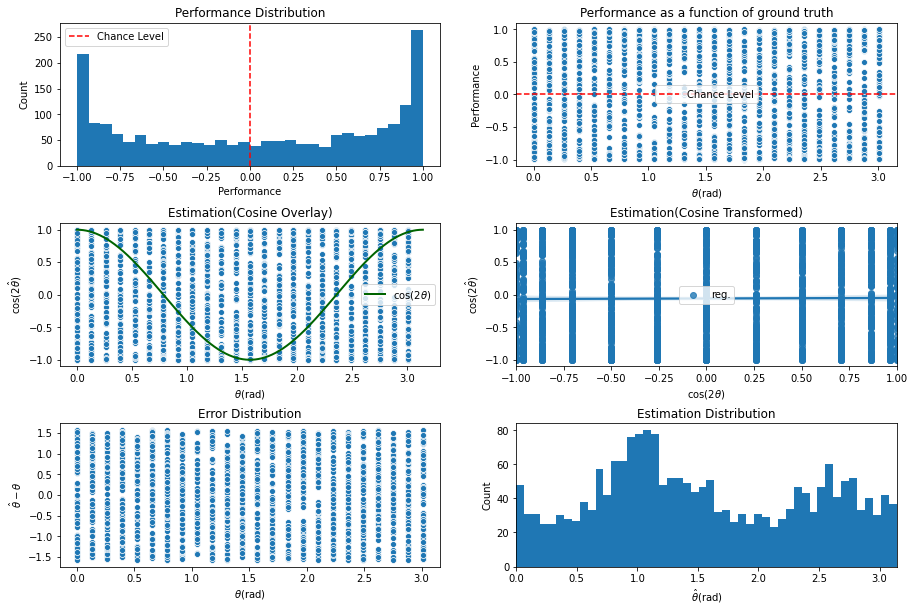

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter175\assets

 Training performance: 
Iter.  176 | Performance 0.0761 | Loss 0.3860 | Spike loss 2.1358
Testing performance: 
Iter.  176 | Performance 0.0596 | Loss 0.3828 | Spike loss 2.1302

 Training performance: 
Iter.  177 | Performance 0.0570 | Loss 0.3832 | Spike loss 2.1282
Testing performance: 
Iter.  177 | Performance 0.0478 | Loss 0.3748 | Spike loss 2.1156

 Training performance: 
Iter.  178 | Performance 0.0797 | Loss 0.3750 | Spike loss 2.1206
Testing performance: 
Iter.  178 | Performance 0.0422 | Loss 0.3779 | Spike loss 2.1044

 Training performance: 
Iter.  179 | Performance 0.0560 | Loss 0.3777 | Spike loss 2.1062
Testing performance: 
Iter.  179 | Performance 0.0346 | Loss 0.3838 | Spike loss 2.1007

 Training performance: 
Iter.  180 | Performance 0.0467 | Loss 0.3858 | Spike loss 2.0972
Testing performance: 
Iter.  180 | Performance 0.0267 | Loss 0.3827 | Spike loss 2.0985

 Trainin

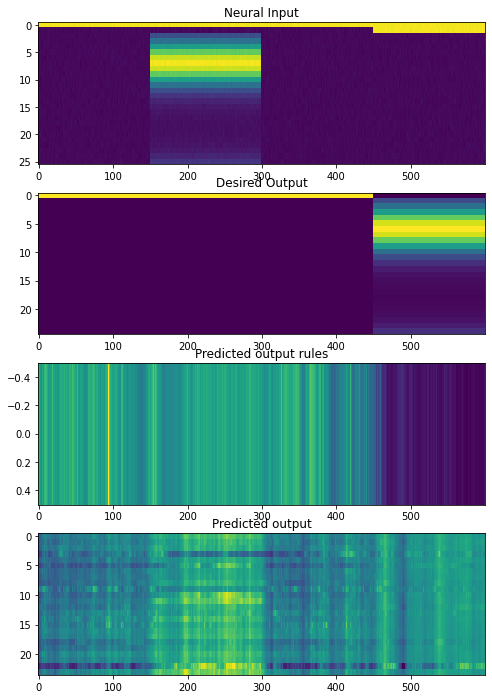

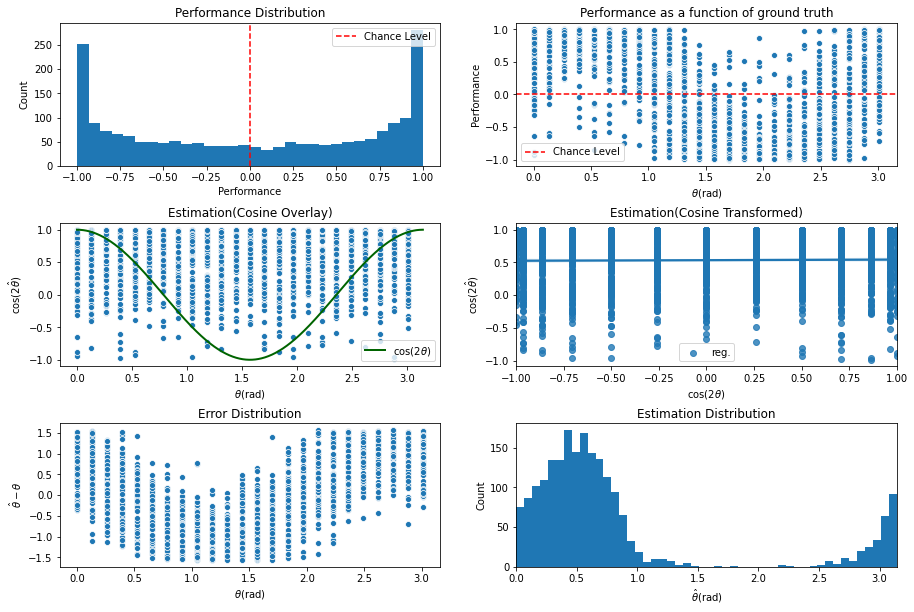

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter200\assets

 Training performance: 
Iter.  201 | Performance -0.0036 | Loss 0.3754 | Spike loss 2.1403
Testing performance: 
Iter.  201 | Performance 0.0307 | Loss 0.3689 | Spike loss 2.1333

 Training performance: 
Iter.  202 | Performance 0.0467 | Loss 0.3690 | Spike loss 2.1322
Testing performance: 
Iter.  202 | Performance 0.0383 | Loss 0.3724 | Spike loss 2.1271

 Training performance: 
Iter.  203 | Performance 0.0558 | Loss 0.3727 | Spike loss 2.1196
Testing performance: 
Iter.  203 | Performance 0.0470 | Loss 0.3777 | Spike loss 2.1257

 Training performance: 
Iter.  204 | Performance 0.0476 | Loss 0.3778 | Spike loss 2.1248
Testing performance: 
Iter.  204 | Performance 0.0631 | Loss 0.3761 | Spike loss 2.1258

 Training performance: 
Iter.  205 | Performance 0.0318 | Loss 0.3749 | Spike loss 2.1283
Testing performance: 
Iter.  205 | Performance 0.0429 | Loss 0.3683 | Spike loss 2.1369

 Traini

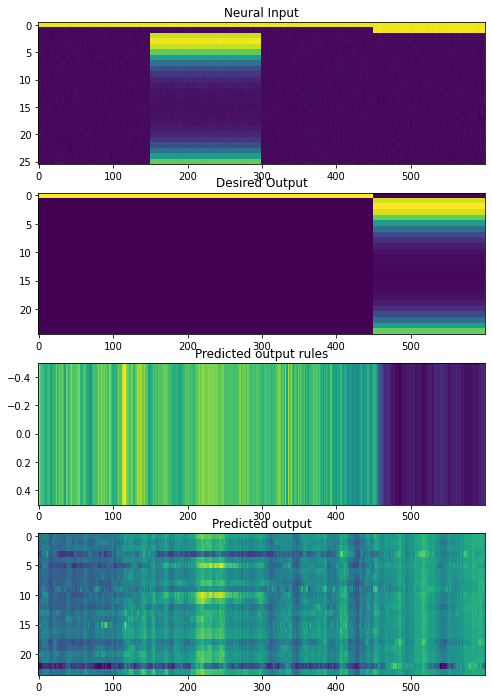

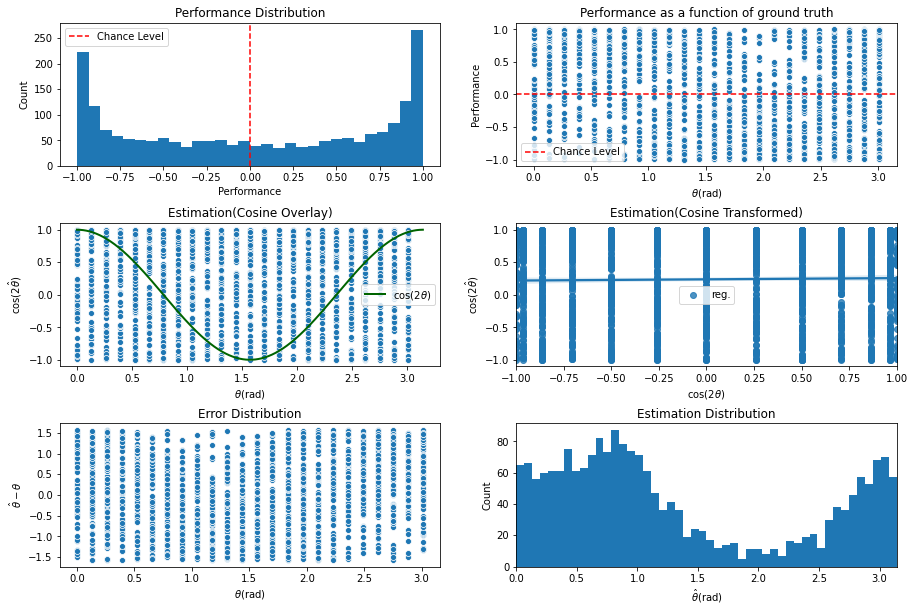

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter225\assets

 Training performance: 
Iter.  226 | Performance 0.0605 | Loss 0.3628 | Spike loss 2.1695
Testing performance: 
Iter.  226 | Performance 0.0484 | Loss 0.3668 | Spike loss 2.1586

 Training performance: 
Iter.  227 | Performance 0.0269 | Loss 0.3660 | Spike loss 2.1515
Testing performance: 
Iter.  227 | Performance 0.0493 | Loss 0.3731 | Spike loss 2.1514

 Training performance: 
Iter.  228 | Performance 0.0333 | Loss 0.3723 | Spike loss 2.1490
Testing performance: 
Iter.  228 | Performance 0.0684 | Loss 0.3704 | Spike loss 2.1552

 Training performance: 
Iter.  229 | Performance 0.0288 | Loss 0.3702 | Spike loss 2.1545
Testing performance: 
Iter.  229 | Performance 0.0327 | Loss 0.3631 | Spike loss 2.1673

 Training performance: 
Iter.  230 | Performance 0.0322 | Loss 0.3630 | Spike loss 2.1607
Testing performance: 
Iter.  230 | Performance 0.0606 | Loss 0.3644 | Spike loss 2.1786

 Trainin

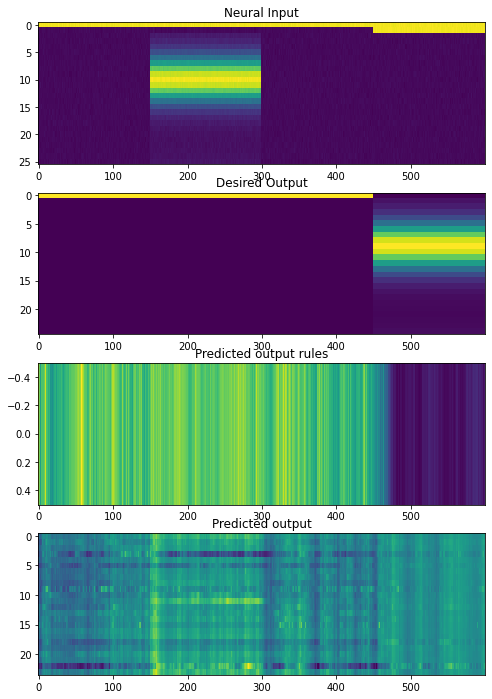

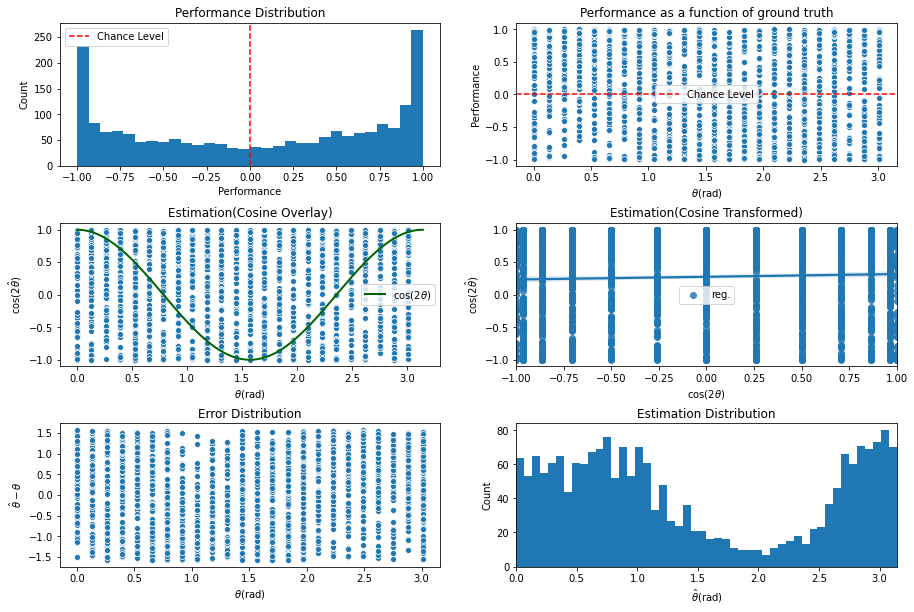

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter250\assets

 Training performance: 
Iter.  251 | Performance 0.0506 | Loss 0.3612 | Spike loss 2.1964
Testing performance: 
Iter.  251 | Performance 0.0272 | Loss 0.3670 | Spike loss 2.1896

 Training performance: 
Iter.  252 | Performance 0.0426 | Loss 0.3674 | Spike loss 2.1872
Testing performance: 
Iter.  252 | Performance 0.0358 | Loss 0.3656 | Spike loss 2.1917

 Training performance: 
Iter.  253 | Performance 0.0375 | Loss 0.3645 | Spike loss 2.1936
Testing performance: 
Iter.  253 | Performance 0.0191 | Loss 0.3587 | Spike loss 2.1964

 Training performance: 
Iter.  254 | Performance 0.0306 | Loss 0.3586 | Spike loss 2.1997
Testing performance: 
Iter.  254 | Performance 0.0142 | Loss 0.3603 | Spike loss 2.2140

 Training performance: 
Iter.  255 | Performance 0.0382 | Loss 0.3593 | Spike loss 2.2064
Testing performance: 
Iter.  255 | Performance 0.0200 | Loss 0.3647 | Spike loss 2.2175

 Trainin

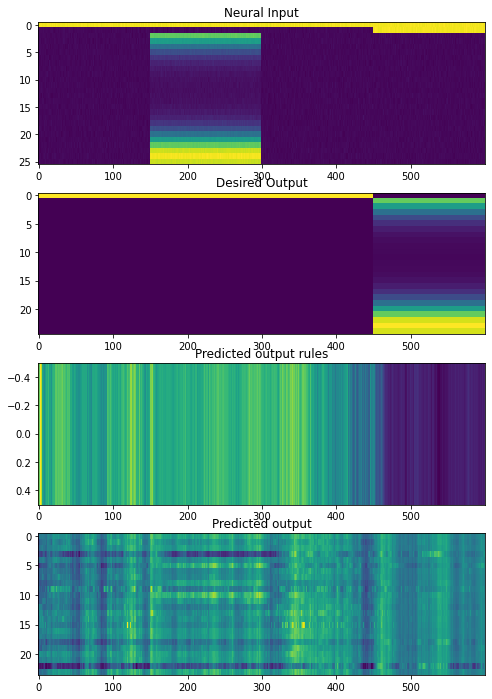

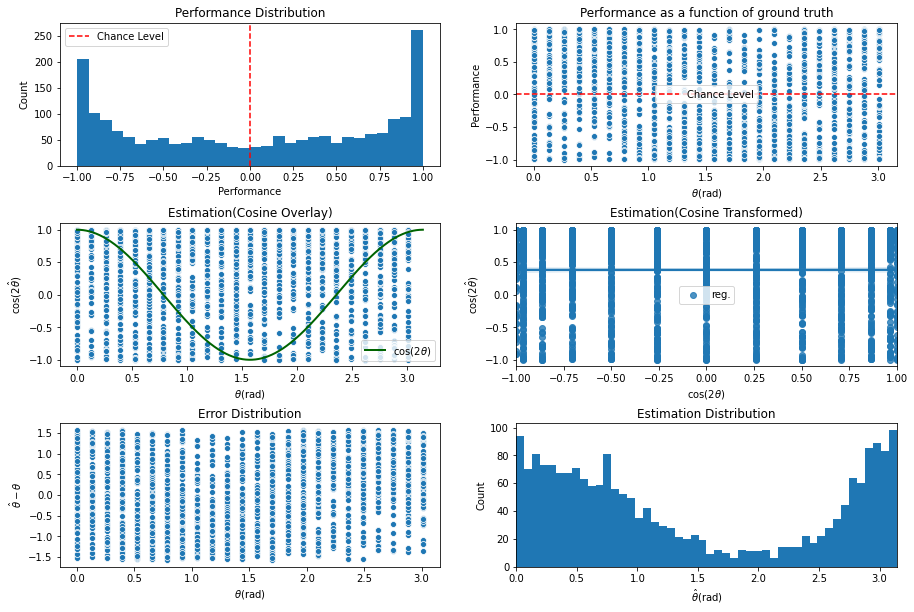

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter275\assets

 Training performance: 
Iter.  276 | Performance 0.0431 | Loss 0.3635 | Spike loss 2.2247
Testing performance: 
Iter.  276 | Performance 0.0314 | Loss 0.3608 | Spike loss 2.2226

 Training performance: 
Iter.  277 | Performance 0.0429 | Loss 0.3608 | Spike loss 2.2281
Testing performance: 
Iter.  277 | Performance 0.0204 | Loss 0.3545 | Spike loss 2.2352

 Training performance: 
Iter.  278 | Performance 0.0316 | Loss 0.3543 | Spike loss 2.2422
Testing performance: 
Iter.  278 | Performance 0.0312 | Loss 0.3556 | Spike loss 2.2485

 Training performance: 
Iter.  279 | Performance 0.0368 | Loss 0.3553 | Spike loss 2.2459
Testing performance: 
Iter.  279 | Performance 0.0216 | Loss 0.3604 | Spike loss 2.2536

 Training performance: 
Iter.  280 | Performance 0.0279 | Loss 0.3603 | Spike loss 2.2587
Testing performance: 
Iter.  280 | Performance 0.0102 | Loss 0.3586 | Spike loss 2.2555

 Trainin

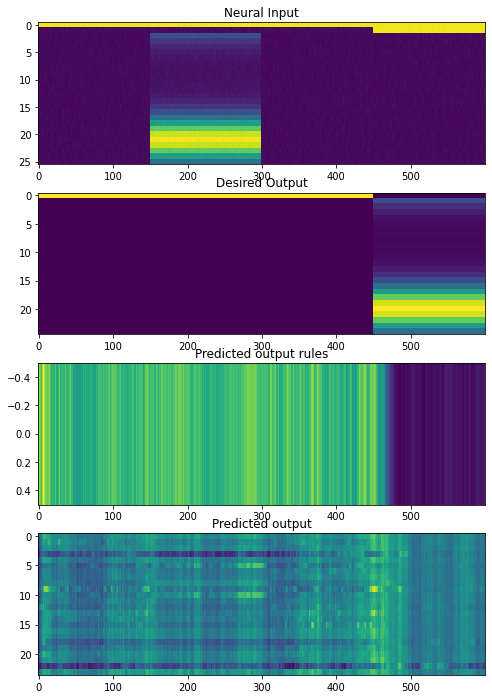

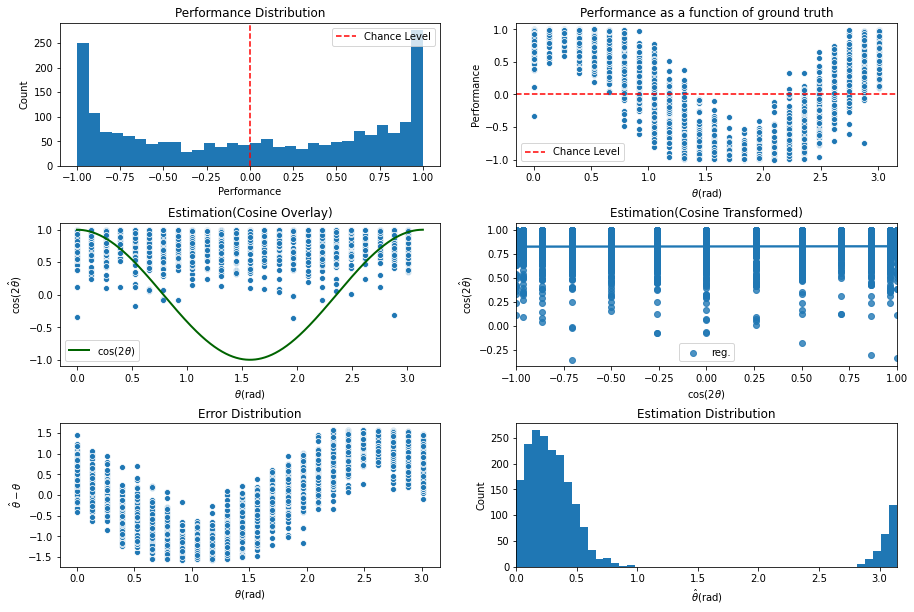

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter300\assets

 Training performance: 
Iter.  301 | Performance 0.0310 | Loss 0.3574 | Spike loss 2.2593
Testing performance: 
Iter.  301 | Performance 0.0138 | Loss 0.3509 | Spike loss 2.2688

 Training performance: 
Iter.  302 | Performance 0.0156 | Loss 0.3510 | Spike loss 2.2725
Testing performance: 
Iter.  302 | Performance 0.0133 | Loss 0.3519 | Spike loss 2.2851

 Training performance: 
Iter.  303 | Performance 0.0311 | Loss 0.3512 | Spike loss 2.2820
Testing performance: 
Iter.  303 | Performance 0.0175 | Loss 0.3561 | Spike loss 2.2932

 Training performance: 
Iter.  304 | Performance 0.0243 | Loss 0.3557 | Spike loss 2.2912
Testing performance: 
Iter.  304 | Performance 0.0189 | Loss 0.3543 | Spike loss 2.2923

 Training performance: 
Iter.  305 | Performance 0.0643 | Loss 0.3544 | Spike loss 2.3070
Testing performance: 
Iter.  305 | Performance 0.0066 | Loss 0.3498 | Spike loss 2.2884

 Trainin

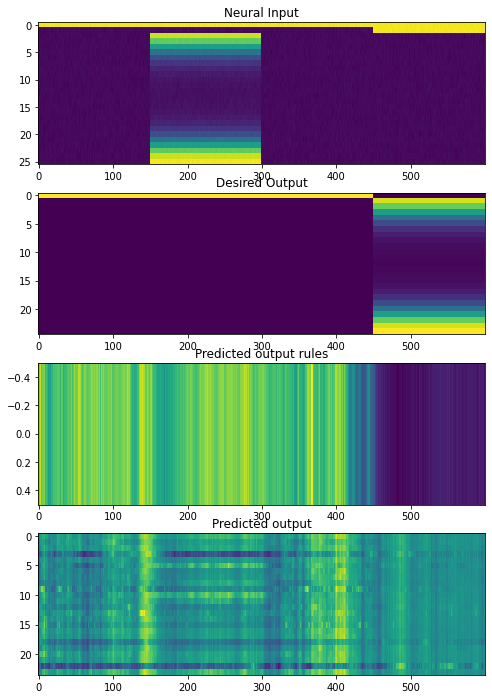

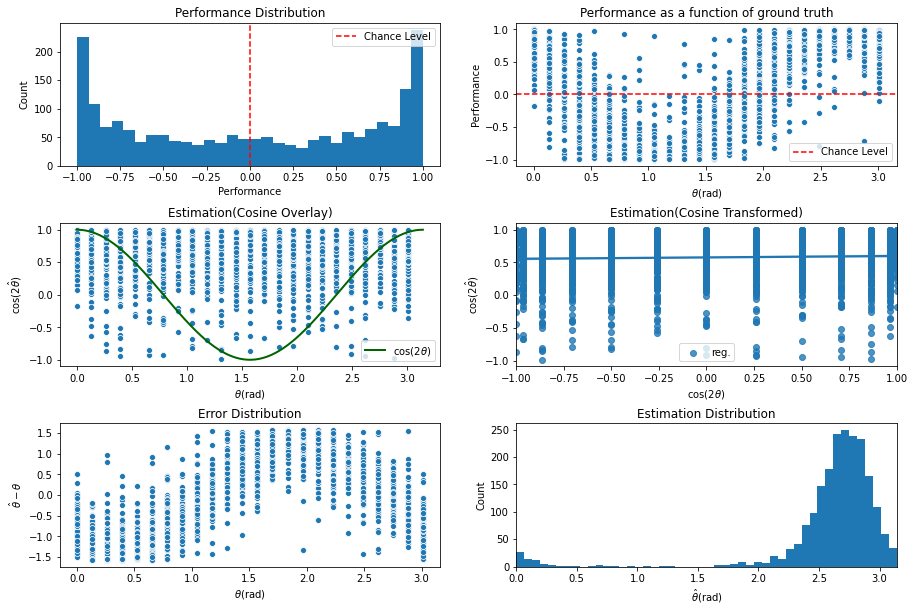

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter325\assets

 Training performance: 
Iter.  326 | Performance 0.0166 | Loss 0.3478 | Spike loss 2.3202
Testing performance: 
Iter.  326 | Performance 0.0387 | Loss 0.3484 | Spike loss 2.3278

 Training performance: 
Iter.  327 | Performance 0.0229 | Loss 0.3483 | Spike loss 2.3329
Testing performance: 
Iter.  327 | Performance 0.0460 | Loss 0.3527 | Spike loss 2.3417

 Training performance: 
Iter.  328 | Performance 0.0499 | Loss 0.3528 | Spike loss 2.3389
Testing performance: 
Iter.  328 | Performance 0.0617 | Loss 0.3504 | Spike loss 2.3313

 Training performance: 
Iter.  329 | Performance 0.0324 | Loss 0.3511 | Spike loss 2.3319
Testing performance: 
Iter.  329 | Performance 0.0546 | Loss 0.3462 | Spike loss 2.3306

 Training performance: 
Iter.  330 | Performance 0.0419 | Loss 0.3463 | Spike loss 2.3241
Testing performance: 
Iter.  330 | Performance 0.0443 | Loss 0.3494 | Spike loss 2.3224

 Trainin

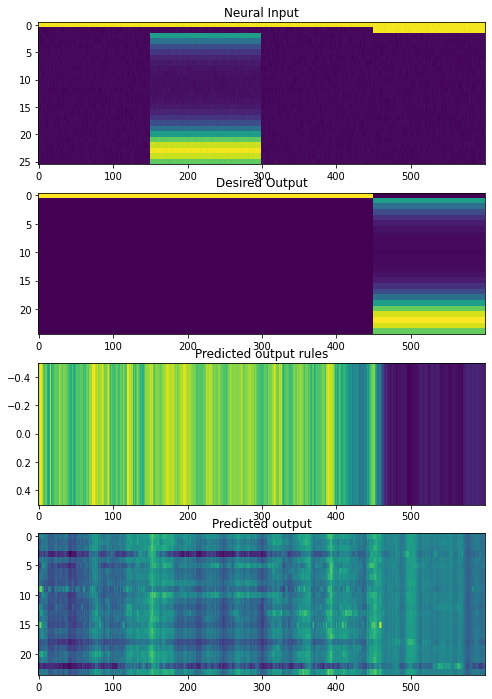

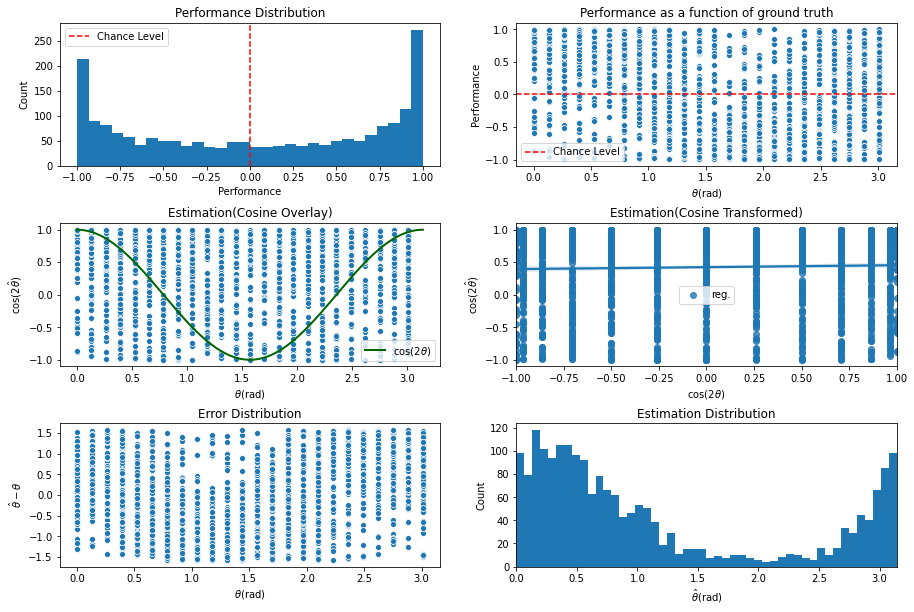

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter350\assets

 Training performance: 
Iter.  351 | Performance 0.0513 | Loss 0.3455 | Spike loss 2.3612
Testing performance: 
Iter.  351 | Performance 0.0410 | Loss 0.3500 | Spike loss 2.3682

 Training performance: 
Iter.  352 | Performance 0.0519 | Loss 0.3496 | Spike loss 2.3714
Testing performance: 
Iter.  352 | Performance 0.0116 | Loss 0.3492 | Spike loss 2.3627

 Training performance: 
Iter.  353 | Performance 0.0337 | Loss 0.3485 | Spike loss 2.3664
Testing performance: 
Iter.  353 | Performance 0.0173 | Loss 0.3435 | Spike loss 2.3609

 Training performance: 
Iter.  354 | Performance 0.0226 | Loss 0.3438 | Spike loss 2.3547
Testing performance: 
Iter.  354 | Performance 0.0052 | Loss 0.3472 | Spike loss 2.3526

 Training performance: 
Iter.  355 | Performance 0.0399 | Loss 0.3472 | Spike loss 2.3467
Testing performance: 
Iter.  355 | Performance 0.0447 | Loss 0.3525 | Spike loss 2.3471

 Trainin

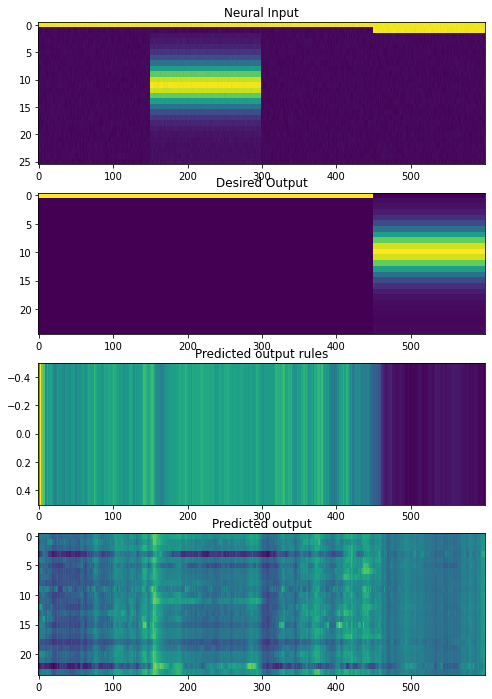

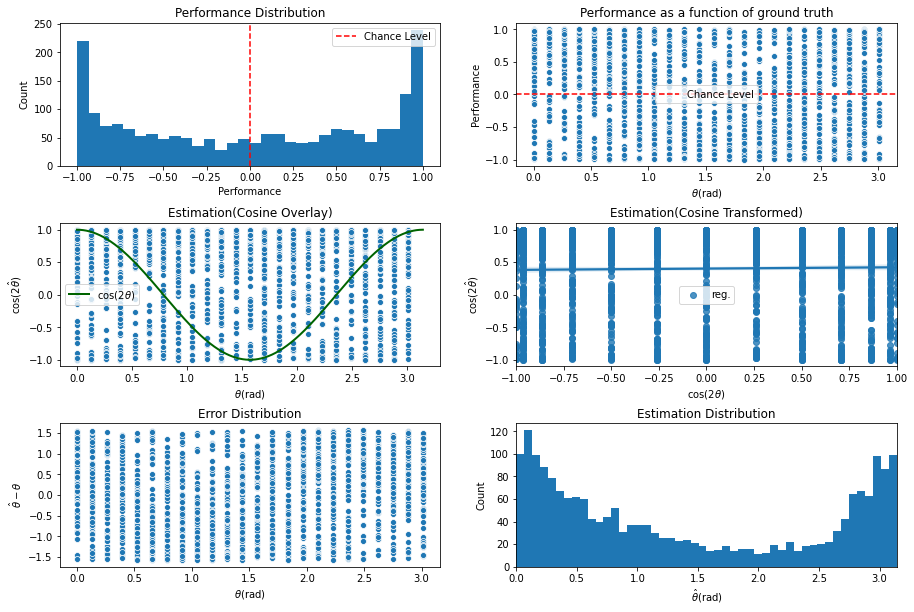

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter375\assets

 Training performance: 
Iter.  376 | Performance 0.0313 | Loss 0.3476 | Spike loss 2.4102
Testing performance: 
Iter.  376 | Performance 0.0475 | Loss 0.3461 | Spike loss 2.4093

 Training performance: 
Iter.  377 | Performance 0.0278 | Loss 0.3462 | Spike loss 2.3963
Testing performance: 
Iter.  377 | Performance 0.0503 | Loss 0.3419 | Spike loss 2.3966

 Training performance: 
Iter.  378 | Performance 0.0439 | Loss 0.3416 | Spike loss 2.3975
Testing performance: 
Iter.  378 | Performance 0.0351 | Loss 0.3449 | Spike loss 2.3919

 Training performance: 
Iter.  379 | Performance 0.0616 | Loss 0.3441 | Spike loss 2.3914
Testing performance: 
Iter.  379 | Performance 0.0263 | Loss 0.3500 | Spike loss 2.3883

 Training performance: 
Iter.  380 | Performance 0.0215 | Loss 0.3494 | Spike loss 2.3873
Testing performance: 
Iter.  380 | Performance 0.0214 | Loss 0.3475 | Spike loss 2.3928

 Trainin

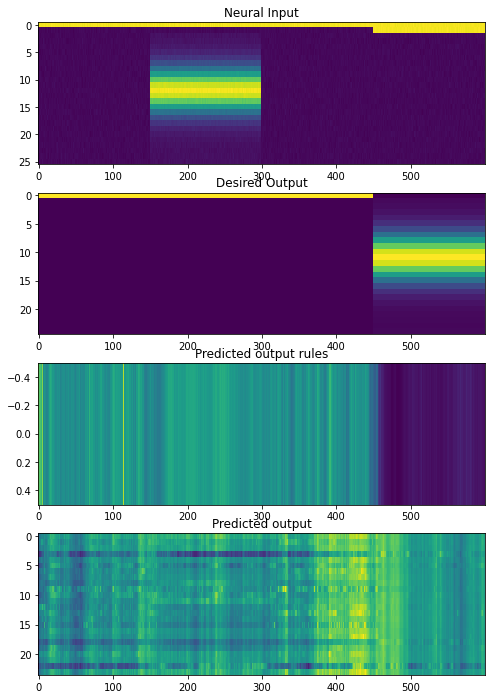

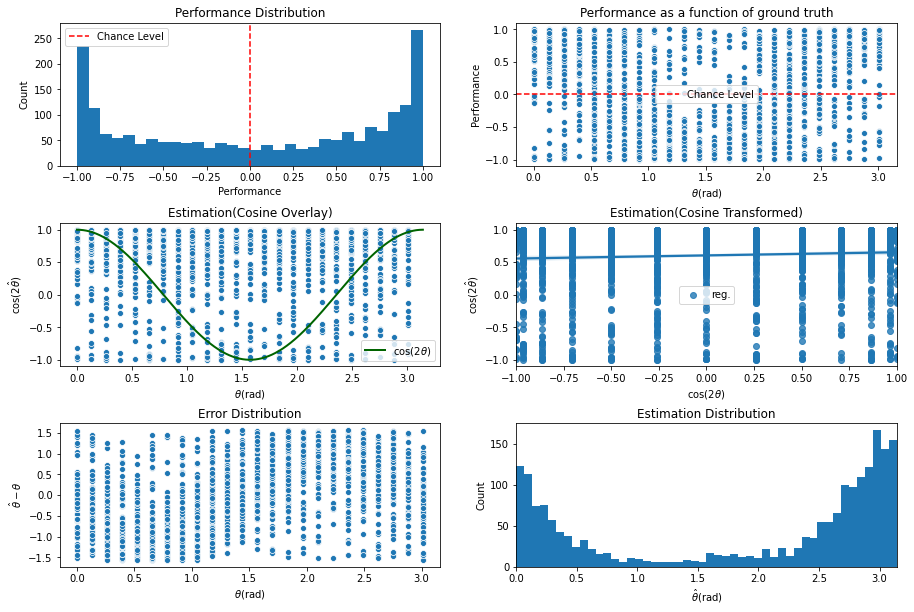

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter400\assets

 Training performance: 
Iter.  401 | Performance 0.0448 | Loss 0.3444 | Spike loss 2.4422
Testing performance: 
Iter.  401 | Performance 0.0382 | Loss 0.3396 | Spike loss 2.4304

 Training performance: 
Iter.  402 | Performance 0.0491 | Loss 0.3395 | Spike loss 2.4398
Testing performance: 
Iter.  402 | Performance 0.0605 | Loss 0.3426 | Spike loss 2.4320

 Training performance: 
Iter.  403 | Performance 0.0421 | Loss 0.3433 | Spike loss 2.4256
Testing performance: 
Iter.  403 | Performance 0.0513 | Loss 0.3477 | Spike loss 2.4230

 Training performance: 
Iter.  404 | Performance 0.0477 | Loss 0.3480 | Spike loss 2.4279
Testing performance: 
Iter.  404 | Performance 0.0523 | Loss 0.3459 | Spike loss 2.4243

 Training performance: 
Iter.  405 | Performance 0.0436 | Loss 0.3463 | Spike loss 2.4252
Testing performance: 
Iter.  405 | Performance 0.0375 | Loss 0.3400 | Spike loss 2.4375

 Trainin

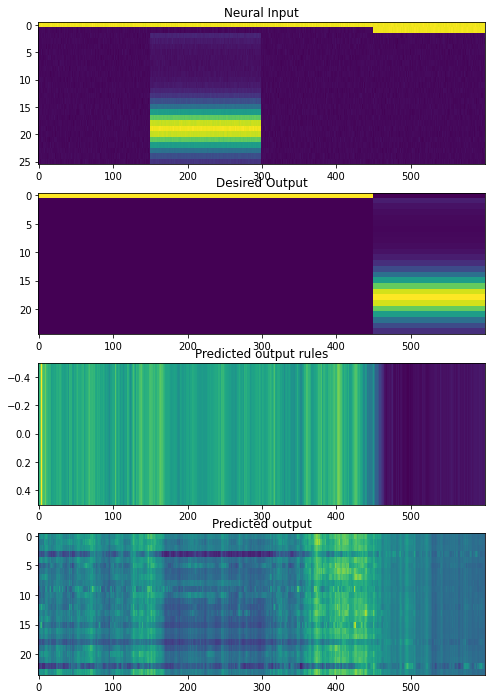

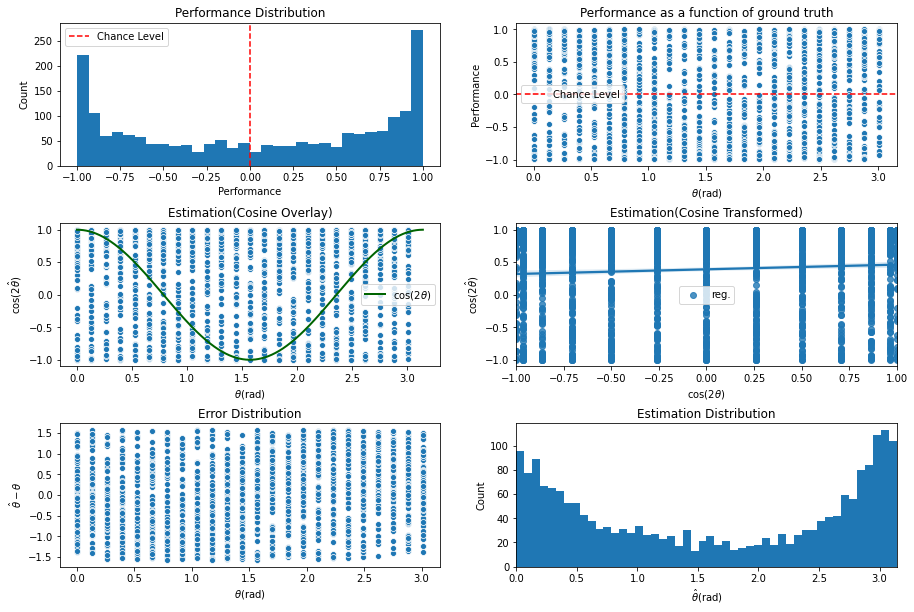

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter425\assets

 Training performance: 
Iter.  426 | Performance 0.0430 | Loss 0.3379 | Spike loss 2.4335
Testing performance: 
Iter.  426 | Performance 0.0609 | Loss 0.3415 | Spike loss 2.4282

 Training performance: 
Iter.  427 | Performance 0.0256 | Loss 0.3416 | Spike loss 2.4257
Testing performance: 
Iter.  427 | Performance 0.0448 | Loss 0.3462 | Spike loss 2.4299

 Training performance: 
Iter.  428 | Performance 0.0463 | Loss 0.3462 | Spike loss 2.4239
Testing performance: 
Iter.  428 | Performance 0.0514 | Loss 0.3447 | Spike loss 2.4244

 Training performance: 
Iter.  429 | Performance 0.0365 | Loss 0.3447 | Spike loss 2.4339
Testing performance: 
Iter.  429 | Performance 0.0345 | Loss 0.3387 | Spike loss 2.4415

 Training performance: 
Iter.  430 | Performance 0.0159 | Loss 0.3386 | Spike loss 2.4384
Testing performance: 
Iter.  430 | Performance 0.0400 | Loss 0.3396 | Spike loss 2.4476

 Trainin

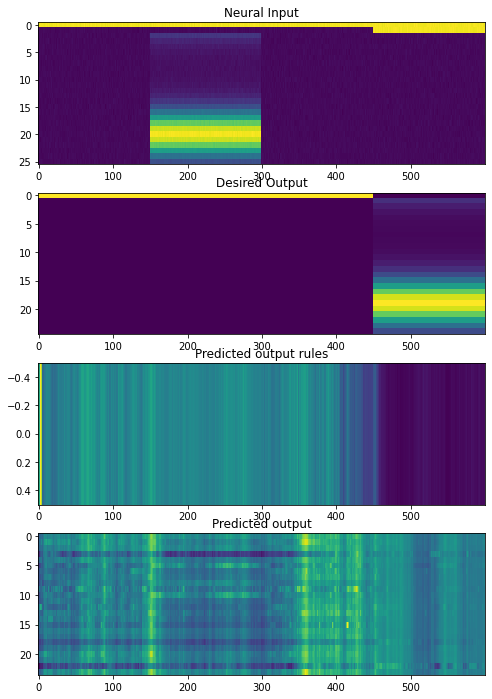

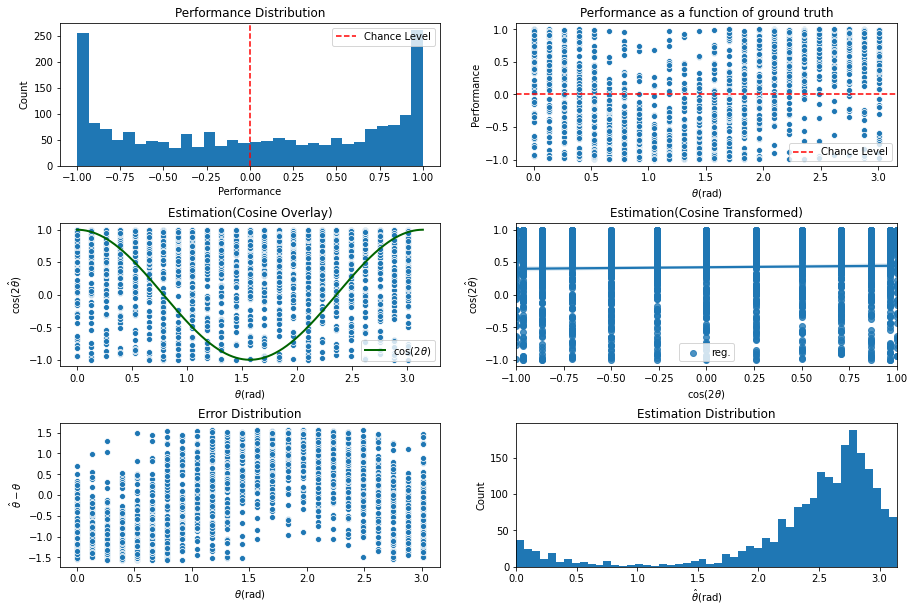

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter450\assets

 Training performance: 
Iter.  451 | Performance 0.0287 | Loss 0.3392 | Spike loss 2.4289
Testing performance: 
Iter.  451 | Performance 0.0307 | Loss 0.3443 | Spike loss 2.4274

 Training performance: 
Iter.  452 | Performance 0.0457 | Loss 0.3442 | Spike loss 2.4247
Testing performance: 
Iter.  452 | Performance 0.0211 | Loss 0.3429 | Spike loss 2.4270

 Training performance: 
Iter.  453 | Performance 0.0118 | Loss 0.3430 | Spike loss 2.4304
Testing performance: 
Iter.  453 | Performance 0.0320 | Loss 0.3374 | Spike loss 2.4344

 Training performance: 
Iter.  454 | Performance 0.0156 | Loss 0.3372 | Spike loss 2.4365
Testing performance: 
Iter.  454 | Performance 0.0325 | Loss 0.3378 | Spike loss 2.4418

 Training performance: 
Iter.  455 | Performance 0.0472 | Loss 0.3379 | Spike loss 2.4468
Testing performance: 
Iter.  455 | Performance 0.0214 | Loss 0.3417 | Spike loss 2.4531

 Trainin

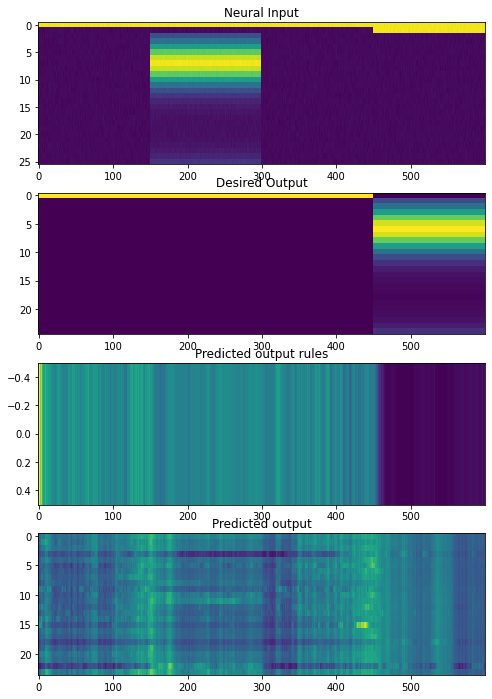

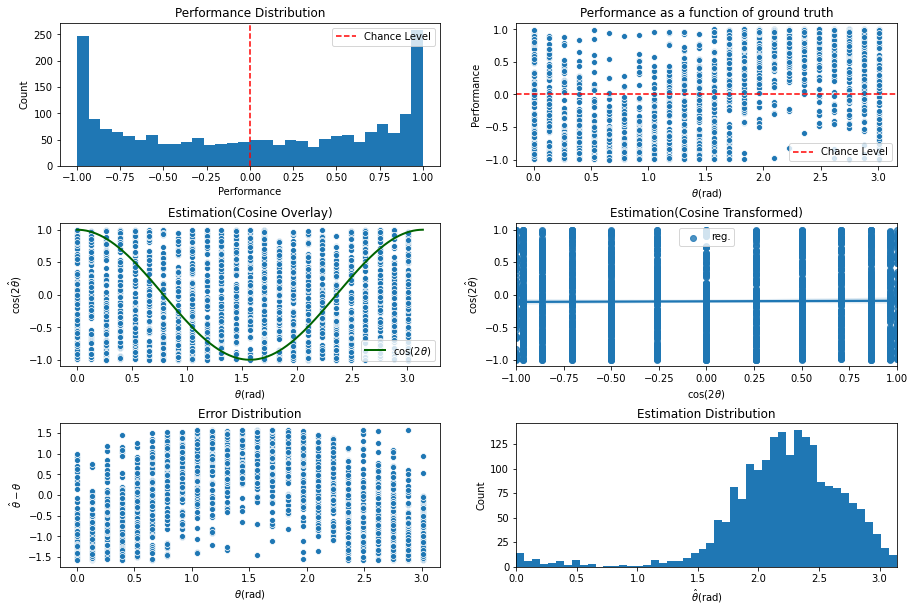

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter475\assets

 Training performance: 
Iter.  476 | Performance 0.0311 | Loss 0.3429 | Spike loss 2.4354
Testing performance: 
Iter.  476 | Performance 0.0112 | Loss 0.3416 | Spike loss 2.4389

 Training performance: 
Iter.  477 | Performance 0.0305 | Loss 0.3418 | Spike loss 2.4324
Testing performance: 
Iter.  477 | Performance 0.0349 | Loss 0.3360 | Spike loss 2.4406

 Training performance: 
Iter.  478 | Performance 0.0259 | Loss 0.3359 | Spike loss 2.4381
Testing performance: 
Iter.  478 | Performance 0.0449 | Loss 0.3368 | Spike loss 2.4486

 Training performance: 
Iter.  479 | Performance 0.0491 | Loss 0.3368 | Spike loss 2.4500
Testing performance: 
Iter.  479 | Performance 0.0709 | Loss 0.3412 | Spike loss 2.4541

 Training performance: 
Iter.  480 | Performance 0.0197 | Loss 0.3408 | Spike loss 2.4532
Testing performance: 
Iter.  480 | Performance 0.0391 | Loss 0.3396 | Spike loss 2.4518

 Trainin

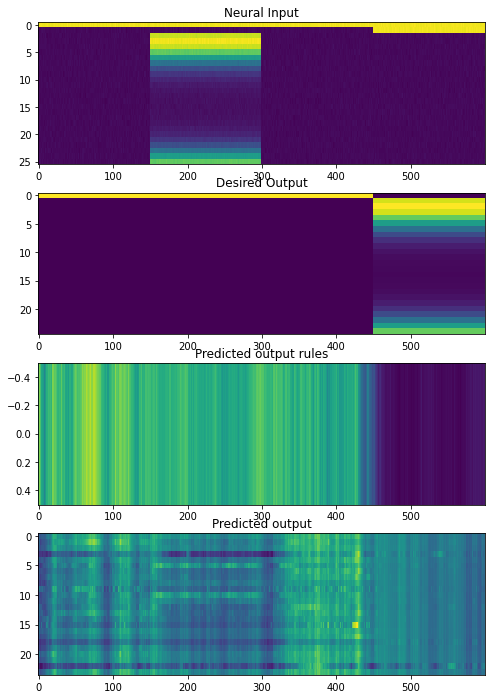

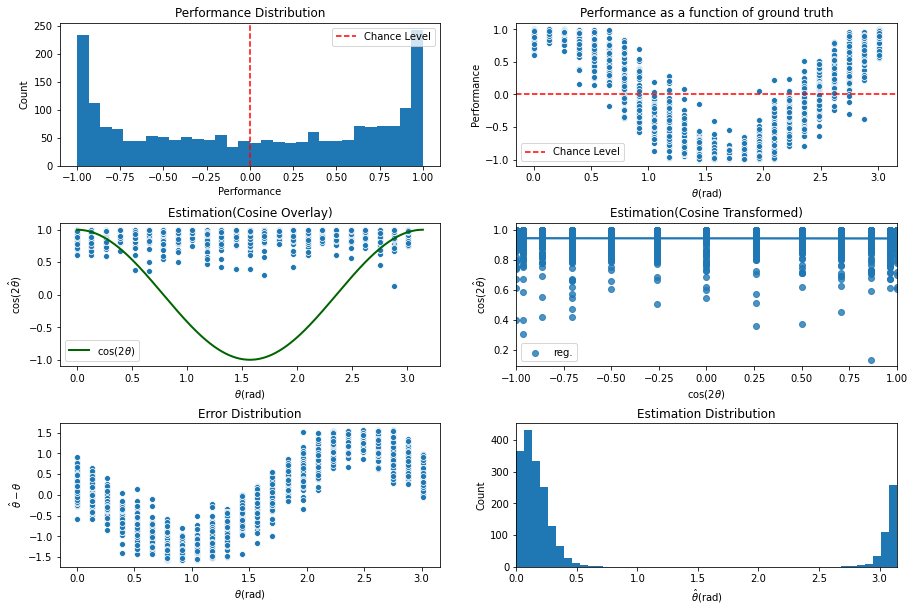

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter500\assets

 Training performance: 
Iter.  501 | Performance 0.0218 | Loss 0.3400 | Spike loss 2.4291
Testing performance: 
Iter.  501 | Performance 0.0097 | Loss 0.3352 | Spike loss 2.4313

 Training performance: 
Iter.  502 | Performance 0.0306 | Loss 0.3346 | Spike loss 2.4433
Testing performance: 
Iter.  502 | Performance 0.0196 | Loss 0.3363 | Spike loss 2.4498

 Training performance: 
Iter.  503 | Performance 0.0285 | Loss 0.3360 | Spike loss 2.4473
Testing performance: 
Iter.  503 | Performance 0.0130 | Loss 0.3405 | Spike loss 2.4574

 Training performance: 
Iter.  504 | Performance 0.0279 | Loss 0.3400 | Spike loss 2.4547
Testing performance: 
Iter.  504 | Performance 0.0186 | Loss 0.3385 | Spike loss 2.4502

 Training performance: 
Iter.  505 | Performance 0.0451 | Loss 0.3382 | Spike loss 2.4536
Testing performance: 
Iter.  505 | Performance 0.0099 | Loss 0.3340 | Spike loss 2.4499

 Trainin

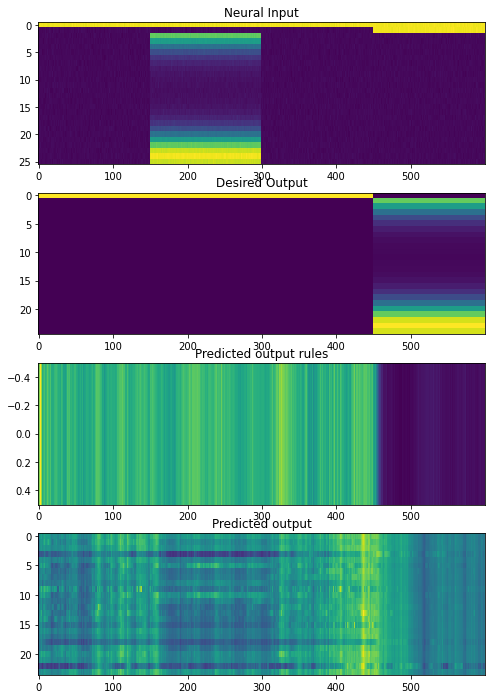

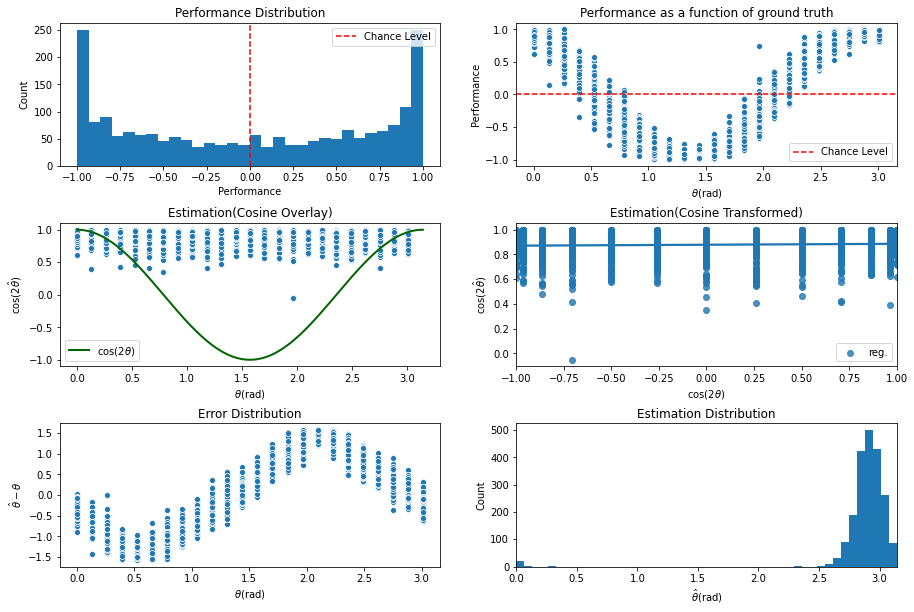

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter525\assets

 Training performance: 
Iter.  526 | Performance 0.0280 | Loss 0.3337 | Spike loss 2.4334
Testing performance: 
Iter.  526 | Performance 0.0129 | Loss 0.3353 | Spike loss 2.4467

 Training performance: 
Iter.  527 | Performance 0.0273 | Loss 0.3354 | Spike loss 2.4486
Testing performance: 
Iter.  527 | Performance 0.0182 | Loss 0.3387 | Spike loss 2.4543

 Training performance: 
Iter.  528 | Performance 0.0106 | Loss 0.3385 | Spike loss 2.4584
Testing performance: 
Iter.  528 | Performance 0.0152 | Loss 0.3367 | Spike loss 2.4548

 Training performance: 
Iter.  529 | Performance 0.0037 | Loss 0.3368 | Spike loss 2.4541
Testing performance: 
Iter.  529 | Performance 0.0151 | Loss 0.3333 | Spike loss 2.4485

 Training performance: 
Iter.  530 | Performance 0.0227 | Loss 0.3330 | Spike loss 2.4521
Testing performance: 
Iter.  530 | Performance 0.0159 | Loss 0.3357 | Spike loss 2.4400

 Trainin

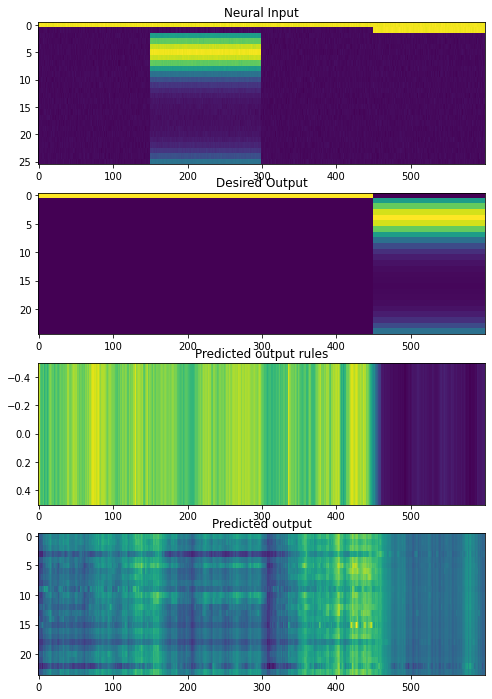

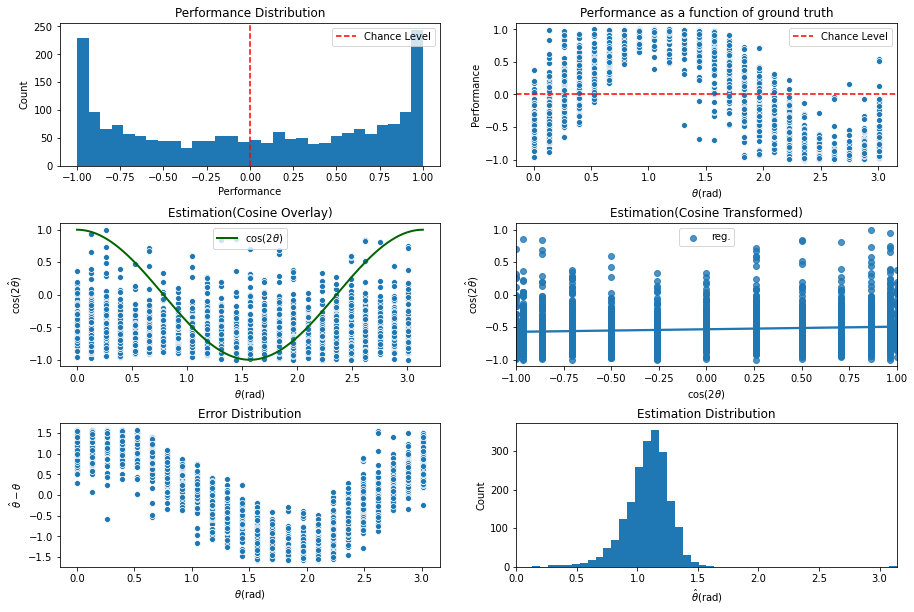

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter550\assets

 Training performance: 
Iter.  551 | Performance 0.0219 | Loss 0.3355 | Spike loss 2.5617
Testing performance: 
Iter.  551 | Performance 0.0280 | Loss 0.3349 | Spike loss 2.5623

 Training performance: 
Iter.  552 | Performance 0.0226 | Loss 0.3352 | Spike loss 2.5648
Testing performance: 
Iter.  552 | Performance 0.0051 | Loss 0.3333 | Spike loss 2.5462

 Training performance: 
Iter.  553 | Performance 0.0363 | Loss 0.3331 | Spike loss 2.5509
Testing performance: 
Iter.  553 | Performance 0.0312 | Loss 0.3321 | Spike loss 2.5351

 Training performance: 
Iter.  554 | Performance 0.0110 | Loss 0.3322 | Spike loss 2.5325
Testing performance: 
Iter.  554 | Performance 0.0474 | Loss 0.3344 | Spike loss 2.5195

 Training performance: 
Iter.  555 | Performance 0.0349 | Loss 0.3341 | Spike loss 2.5219
Testing performance: 
Iter.  555 | Performance 0.0442 | Loss 0.3361 | Spike loss 2.5204

 Trainin

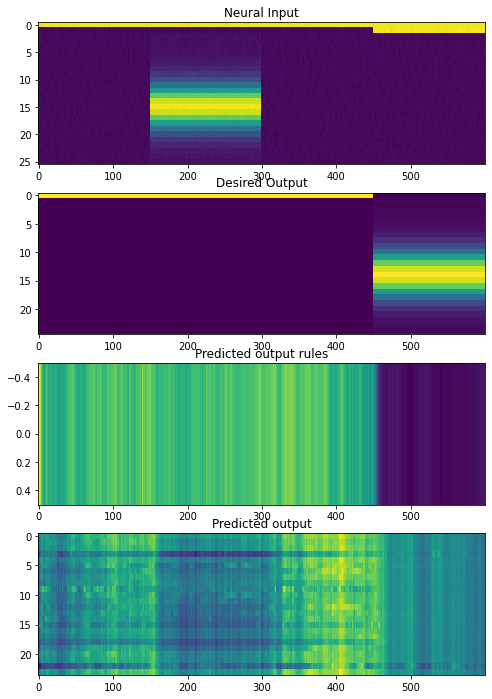

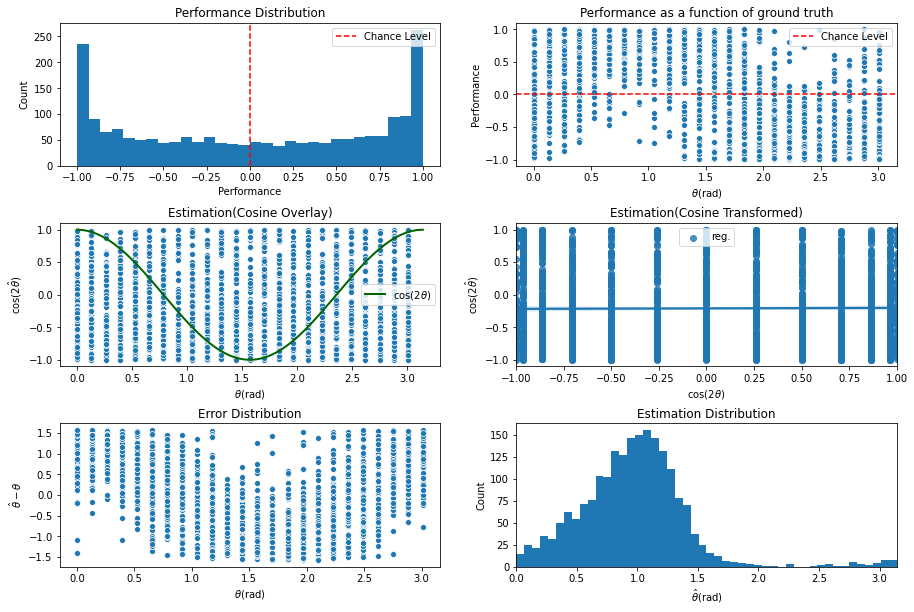

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter575\assets

 Training performance: 
Iter.  576 | Performance 0.0345 | Loss 0.3324 | Spike loss 2.6006
Testing performance: 
Iter.  576 | Performance 0.0377 | Loss 0.3338 | Spike loss 2.5974

 Training performance: 
Iter.  577 | Performance 0.0324 | Loss 0.3343 | Spike loss 2.5957
Testing performance: 
Iter.  577 | Performance 0.0104 | Loss 0.3320 | Spike loss 2.5849

 Training performance: 
Iter.  578 | Performance 0.0162 | Loss 0.3319 | Spike loss 2.5872
Testing performance: 
Iter.  578 | Performance 0.0209 | Loss 0.3304 | Spike loss 2.5795

 Training performance: 
Iter.  579 | Performance 0.0204 | Loss 0.3307 | Spike loss 2.5808
Testing performance: 
Iter.  579 | Performance 0.0122 | Loss 0.3312 | Spike loss 2.5695

 Training performance: 
Iter.  580 | Performance 0.0050 | Loss 0.3315 | Spike loss 2.5679
Testing performance: 
Iter.  580 | Performance 0.0114 | Loss 0.3305 | Spike loss 2.5682

 Trainin

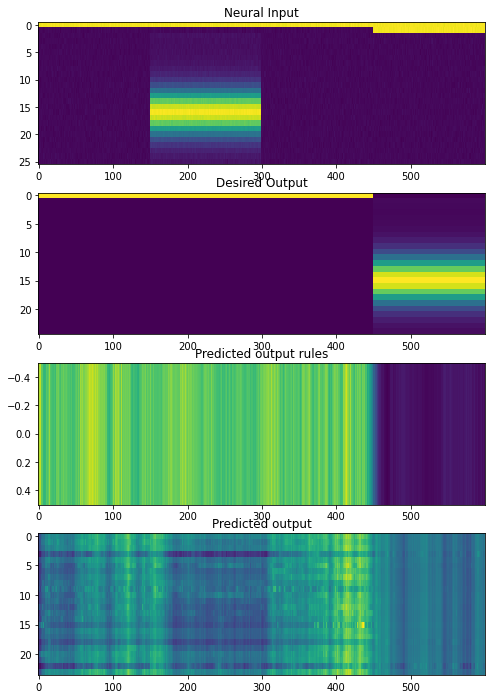

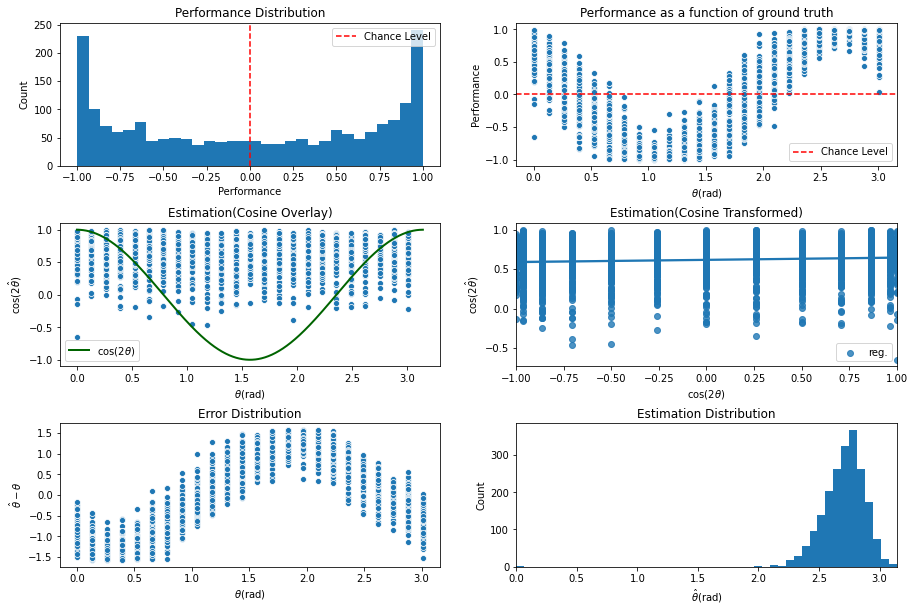

INFO:tensorflow:Assets written to: ../experiments/naturalprior/200622_24ori/cont_iter600\assets

 Training performance: 
Iter.  601 | Performance 0.0191 | Loss 0.3317 | Spike loss 2.5879
Testing performance: 
Iter.  601 | Performance 0.0093 | Loss 0.3303 | Spike loss 2.5907

 Training performance: 
Iter.  602 | Performance 0.0066 | Loss 0.3303 | Spike loss 2.5901
Testing performance: 
Iter.  602 | Performance 0.0217 | Loss 0.3307 | Spike loss 2.5913

 Training performance: 
Iter.  603 | Performance 0.0348 | Loss 0.3310 | Spike loss 2.5867
Testing performance: 
Iter.  603 | Performance 0.0277 | Loss 0.3311 | Spike loss 2.5793

 Training performance: 
Iter.  604 | Performance -0.0067 | Loss 0.3308 | Spike loss 2.5835
Testing performance: 
Iter.  604 | Performance 0.0139 | Loss 0.3300 | Spike loss 2.5807

 Training performance: 
Iter.  605 | Performance 0.0397 | Loss 0.3299 | Spike loss 2.5759
Testing performance: 
Iter.  605 | Performance 0.0217 | Loss 0.3308 | Spike loss 2.5816

 Traini

In [ ]:
###### Train network ######
model_dir = "../experiments/naturalprior/200622_24ori/"
os.makedirs(model_dir, exist_ok=True)

N_iter = 10000
N_save = 25  # save model every N_save iterations

# define model
hp = utils_train.hp
hp['learning_rate'] = 5e-3
model = Model(hp=hp)

alllosses =[]
performance_train = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}
performance_test = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}

for iter_n in range(N_iter+1):
    # train on testing set
    train_data = utils_train.tensorize_trial(stim_test.generate_trial())
    Y, Loss = model(train_data, hp)

    performance_train = utils_train.append_model_performance(performance_train,
                                                             train_data, Y, Loss, par_test)
    # append performance on testing set
    test_data = utils_train.tensorize_trial(stim_test.generate_trial(balanced=True))
    test_Y, test_loss = model.return_losses(test_data['neural_input'], test_data['desired_output'],
                                            test_data['mask'], hp)
    performance_test = utils_train.append_model_performance(performance_test,
                                                            test_data, test_Y, test_loss, par_test)
    
    print('\n Training performance: ')
    utils_train.print_results(performance_train, iter_n)
    print('Testing performance: ')
    utils_train.print_results(performance_test, iter_n)
    if (iter_n % N_save) == 0:
        # predict from testing set
        plot_rnn_output(par_test, test_data, test_Y, stim_test, TEST_TRIAL=None)

        test_Y = utils_analysis.softmax_pred_output(test_Y) # change to softmax
        ground_truth, estim_mean, raw_error, beh_perf = utils_analysis.behavior_summary(test_data, test_Y, par=par_test)
        utils_analysis.behavior_figure(ground_truth, estim_mean, raw_error, beh_perf)

        tf.saved_model.save(model, os.path.join(model_dir, "cont_iter" + str(iter_n)))
        
    if iter_n > 20 and np.sum(performance_test['perf'][-20] > 0.95) > 19:
        print('Good performance achieved... saving final model')
        break

# save final model
tf.saved_model.save(model, os.path.join(model_dir, "cont_iter" + str(iter_n)))

In [1]:
#performance_train = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}
#performance_test = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}
plt.figure()
plt.plot(np.arange(100,len(performance_train['perf'])), 
         performance_train['perf'][100:], label='Train')
plt.plot(np.arange(100,len(performance_test['perf'])), 
         performance_test['perf'][100:], label='Test (balanced)')
plt.ylabel('Performance')
plt.ylabel('Iterations')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.arange(100,len(performance_train['perf'])),
         performance_train['loss'][100:], label='Train')
plt.plot(np.arange(100,len(performance_test['perf'])),
         performance_test['loss'][100:], label='Test (balanced)')
plt.ylabel('Loss')
plt.ylabel('Iterations')
plt.yscale('log')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

### Train on 1000 orientations

In [ ]:
###### Train network ######
model_dir = "../experiments/naturalprior/200622/"
os.makedirs(model_dir, exist_ok=True)

N_iter = 10000
N_save = 50  # save model every N_save iterations

# define model
hp = utils_train.hp
hp['learning_rate'] = 5e-3
model = Model(hp=hp)

alllosses =[]
performance_train = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}
performance_test = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}

for iter_n in range(N_iter+1):
    # train on testing set
    train_data = utils_train.tensorize_trial(stim_train.generate_trial())
    Y, Loss = model(train_data, hp)

    performance_train = utils_train.append_model_performance(performance_train,
                                                             train_data, Y, Loss, par_train)
    # append performance on testing set
    test_data = utils_train.tensorize_trial(stim_test.generate_trial(balanced=True))
    test_Y, test_loss = model.return_losses(test_data['neural_input'], test_data['desired_output'],
                                            test_data['mask'], hp)
    performance_test = utils_train.append_model_performance(performance_test,
                                                            test_data, test_Y, test_loss, par_test)

    print('\n Training performance: ')
    utils_train.print_results(performance_train, iter_n)
    print('Testing performance: ')
    utils_train.print_results(performance_test, iter_n)

    if (iter_n % N_save) == 0:
        # predict from testing set
        plot_rnn_output(par_test, test_data, test_Y, stim_test, TEST_TRIAL=None)
        test_Y = utils_analysis.softmax_pred_output(test_Y) # change to softmax
        ground_truth, estim_mean, raw_error, beh_perf = utils_analysis.behavior_summary(test_data, test_Y, par=par_test)
        utils_analysis.behavior_figure(ground_truth, estim_mean, raw_error, beh_perf)

        tf.saved_model.save(model, os.path.join(model_dir, "cont_iter" + str(iter_n)))

    if iter_n > 20 and np.sum(performance_test['perf'][-20] > 0.95) > 19:
        print('Good performance achieved... saving final model')
        break

# save final model
tf.saved_model.save(model, os.path.join(model_dir, "cont_iter" + str(iter_n)))

In [ ]:
#performance_train = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}
#performance_test = {'perf': [], 'loss': [], 'perf_loss': [], 'spike_loss': []}
plt.figure()
plt.plot(np.arange(100,len(performance_train['perf'])), 
         performance_train['perf'][100:], label='Train')
plt.plot(np.arange(100,len(performance_test['perf'])), 
         performance_test['perf'][100:], label='Test (balanced)')
plt.ylabel('Performance')
plt.ylabel('Iterations')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.arange(100,len(performance_train['perf'])),
         performance_train['loss'][100:], label='Train')
plt.plot(np.arange(100,len(performance_test['perf'])),
         performance_test['loss'][100:], label='Test (balanced)')
plt.ylabel('Loss')
plt.ylabel('Iterations')
plt.yscale('log')
plt.legend()
plt.show()